In [1]:
#2.1 Loading the MNIST dataset

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import optimizers


(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
#tfds.show_examples(train_ds , ds_info)

# 2.2 Setting up the data pipeline

def data_pipeline(input, batch_size=64, prefetch_buffer_size=4):
    # Map the dataset to extract images and labels
    input =input.map(lambda image, label: (image, label))
    # Reshape each image to a flat vector
    input = input.map(lambda image, label: (tf.reshape(image, (-1,)), label))
    # Normalize(Scale) image values to be in the range [-1, 1]
    input = input.map(lambda image, label: ((tf.cast(image, tf.float32) / 128) - 1, label))
    # One-hot encode the labels
    input = input.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
    # Shuffle the dataset and create batches of size 4
    input = input.shuffle(1024).batch(batch_size)
    # Prefetch the dataset to improve pipeline performance
    input = input.prefetch(prefetch_buffer_size)
    return input

# Save the datasets after applying the data pipeline
train_dataset = data_pipeline(train_ds)
test_dataset = data_pipeline(test_ds)

for elem in train_dataset.take(1):
    print(elem)

for elem in test_dataset.take(1):
    print(elem)


# 2.3 Building a deep neural network with TensorFlow
class MLPModel(tf.keras.Model):
    def __init__(self, layer_sizes, output_size=10):
        super().__init__()
        self.mlp_layers = []  # create a list to store hidden layers

        # Create hidden layers with ReLU activation
        for layer_size in layer_sizes:
            new_layer = layers.Dense(units=layer_size, activation='relu')
            self.mlp_layers.append(new_layer)
        # Output layer with softmax activation for classification
        self.output_layer = layers.Dense(units=output_size, activation='softmax')

    def call(self, x):
        # Forward pass through hidden layers
        for mlp_layer in self.mlp_layers:
            x = mlp_layer(x)
        # Forward pass through the output layer
        y = self.output_layer(x)
        return y

# 2.4 Training the network
"""
Define a training loop function which receives
• The number of epochs
• The model object
• The training dataset
• The test dataset
• The loss function
• The optimizer
• Different arrays for the different values you want to track for visualization
"""


def train_model(num_epochs, model, train_dataset, test_dataset, loss_function, optimizer):
    train_losses = []
    test_losses = []
    train_accuracies = []  # Track training accuracy
    test_accuracies = []   # Track testing accuracy

    for epoch in range(num_epochs):
        epoch_train_losses = []
        correct_train_predictions = 0  # Counter for correct training predictions
        total_train_samples = 0

        # Training phase
        for x_train, target_train in train_dataset:
            with tf.GradientTape() as tape:
                # Forward pass
                pred_train = model(x_train)
                # Calculate the training loss
                loss_train = loss_function(target_train, pred_train)

            # Calculate gradients
            gradients_train = tape.gradient(loss_train, model.trainable_variables)

            # Update weights using optimizer
            optimizer.apply_gradients(zip(gradients_train, model.trainable_variables))

            # Append the training loss to the list
            epoch_train_losses.append(loss_train.numpy())

            # Calculate training accuracy
            correct_train_predictions += np.sum(np.argmax(target_train, axis=1) == np.argmax(pred_train, axis=1))
            total_train_samples += len(x_train)

        train_accuracy = correct_train_predictions / total_train_samples
        train_accuracies.append(train_accuracy)

        # Testing phase
        epoch_test_losses = []
        correct_test_predictions = 0  # Counter for correct testing predictions
        total_test_samples = 0

        for x_test, target_test in test_dataset:
            # Forward pass
            pred_test = model(x_test)
            # Calculate the testing loss
            loss_test = loss_function(target_test, pred_test)
            epoch_test_losses.append(loss_test.numpy())

            # Calculate testing accuracy
            correct_test_predictions += np.sum(np.argmax(target_test, axis=1) == np.argmax(pred_test, axis=1))
            total_test_samples += len(x_test)

        test_accuracy = correct_test_predictions / total_test_samples
        test_accuracies.append(test_accuracy)

        # Print the mean training and testing loss and accuracy for the epoch
        mean_train_loss = np.mean(epoch_train_losses)
        mean_test_loss = np.mean(epoch_test_losses)
        print(f"Epoch {epoch + 1},\n Train Loss: {mean_train_loss}, Train Accuracy: {train_accuracy},\n Test Loss: {mean_test_loss}, Test Accuracy: {test_accuracy}")

        # Append losses to the lists for visualization
        train_losses.append(mean_train_loss)
        test_losses.append(mean_test_loss)

    return train_losses, test_losses, train_accuracies, test_accuracies

# Example usage
EPOCHS = 10
model = MLPModel(layer_sizes=[256, 256], output_size=10)

# Loss function and optimizer
cce = tf.keras.losses.CategoricalCrossentropy()
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.1)

# Assuming train_dataset and test_dataset are your TensorFlow datasets
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    EPOCHS, model, train_dataset, test_dataset, cce, sgd
)




(<tf.Tensor: shape=(64, 784), dtype=float32, numpy=
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)>, <tf.Tensor: shape=(64, 10), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 

2023-11-21 12:48:25.466352: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-21 12:48:25.505396: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1,
 Train Loss: 0.3582116663455963, Train Accuracy: 0.8881666666666667,
 Test Loss: 0.1517125517129898, Test Accuracy: 0.9541
Epoch 2,
 Train Loss: 0.1385299563407898, Train Accuracy: 0.95675,
 Test Loss: 0.14895199239253998, Test Accuracy: 0.954
Epoch 3,
 Train Loss: 0.10114321112632751, Train Accuracy: 0.9688333333333333,
 Test Loss: 0.19664208590984344, Test Accuracy: 0.9322
Epoch 4,
 Train Loss: 0.08119477331638336, Train Accuracy: 0.97435,
 Test Loss: 0.13763003051280975, Test Accuracy: 0.9551
Epoch 5,
 Train Loss: 0.06527698040008545, Train Accuracy: 0.9793666666666667,
 Test Loss: 0.13002650439739227, Test Accuracy: 0.9556
Epoch 6,
 Train Loss: 0.054415423423051834, Train Accuracy: 0.9826666666666667,
 Test Loss: 0.08227454870939255, Test Accuracy: 0.9739
Epoch 7,
 Train Loss: 0.04550603777170181, Train Accuracy: 0.9858333333333333,
 Test Loss: 0.07622519880533218, Test Accuracy: 0.976
Epoch 8,
 Train Loss: 0.039359696209430695, Train Accuracy: 0.9875333333333334,
 Test Lo

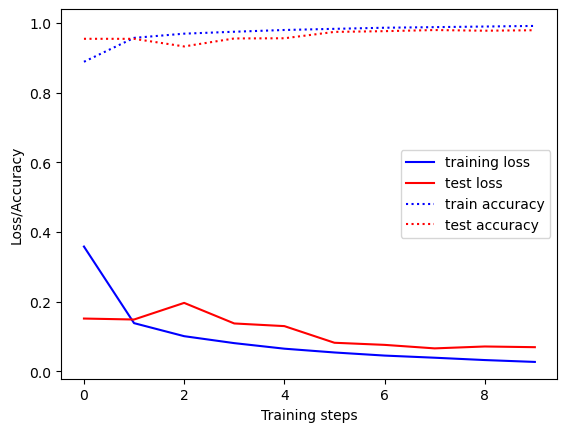

Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.36190342903137207, Train Accuracy: 0.89085,
 Test Loss: 0.2055802047252655, Test Accuracy: 0.9387
Epoch 2,
 Train Loss: 0.1822432577610016, Train Accuracy: 0.9464,
 Test Loss: 0.15766504406929016, Test Accuracy: 0.9541
Epoch 3,
 Train Loss: 0.13292251527309418, Train Accuracy: 0.96085,
 Test Loss: 0.11811594665050507, Test Accuracy: 0.9633
Epoch 4,
 Train Loss: 0.10496339201927185, Train Accuracy: 0.9696333333333333,
 Test Loss: 0.11345448344945908, Test Accuracy: 0.9645
Epoch 5,
 Train Loss: 0.0873931497335434, Train Accuracy: 0.9742833333333333,
 Test Loss: 0.09564381837844849, Test Accuracy: 0.9702
Epoch 6,
 Train Loss: 0.07416035234928131, Train Accuracy: 0.9782833333333333,
 Test Loss: 0.09924016147851944, Test Accuracy: 0.9681
Epoch 7,
 Train Loss: 0.06378782540559769, Train Accuracy: 0.9817666666666667,
 Test Loss: 0.0811547264456749, Test Accuracy: 0.

Epoch 10,
 Train Loss: 0.04289787635207176, Train Accuracy: 0.9874333333333334,
 Test Loss: 0.07407867908477783, Test Accuracy: 0.9783
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 0.5128767490386963, Train Accuracy: 0.85665,
 Test Loss: 0.36383867263793945, Test Accuracy: 0.8926
Epoch 2,
 Train Loss: 0.37632766366004944, Train Accuracy: 0.8922666666666667,
 Test Loss: 0.3644242286682129, Test Accuracy: 0.8982
Epoch 3,
 Train Loss: 0.35122498869895935, Train Accuracy: 0.9015333333333333,
 Test Loss: 0.34770435094833374, Test Accuracy: 0.9066
Epoch 4,
 Train Loss: 0.34440866112709045, Train Accuracy: 0.9038333333333334,
 Test Loss: 0.35633325576782227, Test Accuracy: 0.9044
Epoch 5,
 Train Loss: 0.33175280690193176, Train Accuracy: 0.9091833333333333,
 Test Loss: 0.4286923110485077, Test Accuracy: 0.8898
Epoch 6,
 Train Loss: 0.32617518305778503, Train Accuracy: 0.9113166666666667,
 Test Loss: 0.3941231071

Epoch 10,
 Train Loss: 0.31371307373046875, Train Accuracy: 0.9153666666666667,
 Test Loss: 0.3535541296005249, Test Accuracy: 0.9069
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.839856743812561, Train Accuracy: 0.81815,
 Test Loss: 0.5456848740577698, Test Accuracy: 0.8622
Epoch 2,
 Train Loss: 0.5995309948921204, Train Accuracy: 0.8678833333333333,
 Test Loss: 0.4834959805011749, Test Accuracy: 0.848
Epoch 3,
 Train Loss: 0.6941777467727661, Train Accuracy: 0.8585166666666667,
 Test Loss: 0.6500893831253052, Test Accuracy: 0.8338
Epoch 4,
 Train Loss: 0.8363321423530579, Train Accuracy: 0.8351666666666666,
 Test Loss: 1.5736606121063232, Test Accuracy: 0.8421
Epoch 5,
 Train Loss: 0.8984742760658264, Train Accuracy: 0.8186,
 Test Loss: 0.8145985007286072, Test Accuracy: 0.7924
Epoch 6,
 Train Loss: 0.9574118256568909, Train Accuracy: 0.8063166666666667,
 Test Loss: 1.3525080680847168, Test Accurac

Epoch 10,
 Train Loss: 1.242733359336853, Train Accuracy: 0.7244833333333334,
 Test Loss: 1.0085724592208862, Test Accuracy: 0.76
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.37604066729545593, Train Accuracy: 0.889,
 Test Loss: 0.21723979711532593, Test Accuracy: 0.9335
Epoch 2,
 Train Loss: 0.19279305636882782, Train Accuracy: 0.94295,
 Test Loss: 0.16644276678562164, Test Accuracy: 0.948
Epoch 3,
 Train Loss: 0.14531132578849792, Train Accuracy: 0.9575666666666667,
 Test Loss: 0.12917372584342957, Test Accuracy: 0.9604
Epoch 4,
 Train Loss: 0.1174907311797142, Train Accuracy: 0.9651666666666666,
 Test Loss: 0.12020473927259445, Test Accuracy: 0.9628
Epoch 5,
 Train Loss: 0.09853367507457733, Train Accuracy: 0.9709,
 Test Loss: 0.11110759526491165, Test Accuracy: 0.9655
Epoch 6,
 Train Loss: 0.08599970489740372, Train Accuracy: 0.9739333333333333,
 Test Loss: 0.09212449938058853, Test Accuracy: 0.9708

Epoch 10,
 Train Loss: 0.05346805974841118, Train Accuracy: 0.9836666666666667,
 Test Loss: 0.08075536042451859, Test Accuracy: 0.9741
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.4861673414707184, Train Accuracy: 0.8561,
 Test Loss: 0.43545016646385193, Test Accuracy: 0.8683
Epoch 2,
 Train Loss: 0.3670577108860016, Train Accuracy: 0.8941,
 Test Loss: 0.3997190296649933, Test Accuracy: 0.8882
Epoch 3,
 Train Loss: 0.34555333852767944, Train Accuracy: 0.9031333333333333,
 Test Loss: 0.3720121383666992, Test Accuracy: 0.8947
Epoch 4,
 Train Loss: 0.3362255394458771, Train Accuracy: 0.9062333333333333,
 Test Loss: 0.30277183651924133, Test Accuracy: 0.9117
Epoch 5,
 Train Loss: 0.3311600387096405, Train Accuracy: 0.9071333333333333,
 Test Loss: 0.34256982803344727, Test Accuracy: 0.9042
Epoch 6,
 Train Loss: 0.32150694727897644, Train Accuracy: 0.9112333333333333,
 Test Loss: 0.2748708724975586, Test Acc

Epoch 10,
 Train Loss: 0.3090272843837738, Train Accuracy: 0.9162666666666667,
 Test Loss: 0.3433346450328827, Test Accuracy: 0.9148
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.7455576062202454, Train Accuracy: 0.8165666666666667,
 Test Loss: 0.5606235861778259, Test Accuracy: 0.859
Epoch 2,
 Train Loss: 0.5744231939315796, Train Accuracy: 0.86545,
 Test Loss: 0.5147086381912231, Test Accuracy: 0.8753
Epoch 3,
 Train Loss: 0.6255579590797424, Train Accuracy: 0.8597166666666667,
 Test Loss: 0.6020618677139282, Test Accuracy: 0.8738
Epoch 4,
 Train Loss: 0.6642473340034485, Train Accuracy: 0.8559833333333333,
 Test Loss: 1.281700611114502, Test Accuracy: 0.8454
Epoch 5,
 Train Loss: 0.7455027103424072, Train Accuracy: 0.8439,
 Test Loss: 0.6784137487411499, Test Accuracy: 0.8351
Epoch 6,
 Train Loss: 0.8425865173339844, Train Accuracy: 0.8245333333333333,
 Test Loss: 0.6964503526687622, Test Accuracy

Epoch 10,
 Train Loss: 1.1734747886657715, Train Accuracy: 0.76555,
 Test Loss: 0.9625411629676819, Test Accuracy: 0.7095
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.33971327543258667, Train Accuracy: 0.8966333333333333,
 Test Loss: 0.17352738976478577, Test Accuracy: 0.9485
Epoch 2,
 Train Loss: 0.15743376314640045, Train Accuracy: 0.9524166666666667,
 Test Loss: 0.1437116414308548, Test Accuracy: 0.9565
Epoch 3,
 Train Loss: 0.11319207400083542, Train Accuracy: 0.9654666666666667,
 Test Loss: 0.10540533810853958, Test Accuracy: 0.9683
Epoch 4,
 Train Loss: 0.08733879029750824, Train Accuracy: 0.9736333333333334,
 Test Loss: 0.0978005900979042, Test Accuracy: 0.9694
Epoch 5,
 Train Loss: 0.07042960077524185, Train Accuracy: 0.9787,
 Test Loss: 0.08840829133987427, Test Accuracy: 0.9725
Epoch 6,
 Train Loss: 0.05897832661867142, Train Accuracy: 0.9818166666666667,
 Test Loss: 0.08602237701416016, 

Epoch 10,
 Train Loss: 0.028052274137735367, Train Accuracy: 0.9917166666666667,
 Test Loss: 0.07013555616140366, Test Accuracy: 0.9781
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.4805423617362976, Train Accuracy: 0.8657666666666667,
 Test Loss: 0.5150047540664673, Test Accuracy: 0.8706
Epoch 2,
 Train Loss: 0.3416652977466583, Train Accuracy: 0.9091833333333333,
 Test Loss: 0.31105363368988037, Test Accuracy: 0.9095
Epoch 3,
 Train Loss: 0.32861995697021484, Train Accuracy: 0.9154166666666667,
 Test Loss: 0.30628517270088196, Test Accuracy: 0.917
Epoch 4,
 Train Loss: 0.30440038442611694, Train Accuracy: 0.9228333333333333,
 Test Loss: 0.2806815207004547, Test Accuracy: 0.9287
Epoch 5,
 Train Loss: 0.2990841269493103, Train Accuracy: 0.9256666666666666,
 Test Loss: 0.2814965844154358, Test Accuracy: 0.9308
Epoch 6,
 Train Loss: 0.2789822220802307, Train Accuracy: 0.9311166666666667,
 Test Loss: 

Epoch 10,
 Train Loss: 0.282926470041275, Train Accuracy: 0.9318666666666666,
 Test Loss: 0.2613462209701538, Test Accuracy: 0.9398
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.9726371169090271, Train Accuracy: 0.80095,
 Test Loss: 0.4861316680908203, Test Accuracy: 0.8871
Epoch 2,
 Train Loss: 0.7754066586494446, Train Accuracy: 0.8291333333333334,
 Test Loss: 0.9299142956733704, Test Accuracy: 0.7533
Epoch 3,
 Train Loss: 1.2271705865859985, Train Accuracy: 0.743,
 Test Loss: 1.040286898612976, Test Accuracy: 0.7273
Epoch 4,
 Train Loss: 1.7621943950653076, Train Accuracy: 0.5779833333333333,
 Test Loss: 1.569638967514038, Test Accuracy: 0.5076
Epoch 5,
 Train Loss: 2.6893837451934814, Train Accuracy: 0.4494,
 Test Loss: 1.746724009513855, Test Accuracy: 0.3717
Epoch 6,
 Train Loss: 3.0177183151245117, Train Accuracy: 0.4093833333333333,
 Test Loss: 1.9215084314346313, Test Accuracy: 0.3973
E

Epoch 10,
 Train Loss: 6.295046806335449, Train Accuracy: 0.15895,
 Test Loss: 2.1698999404907227, Test Accuracy: 0.2247
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 64, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.45205408334732056, Train Accuracy: 0.8688833333333333,
 Test Loss: 0.26903975009918213, Test Accuracy: 0.9206
Epoch 2,
 Train Loss: 0.24352777004241943, Train Accuracy: 0.9279833333333334,
 Test Loss: 0.19741764664649963, Test Accuracy: 0.9432
Epoch 3,
 Train Loss: 0.1900893896818161, Train Accuracy: 0.94465,
 Test Loss: 0.16885846853256226, Test Accuracy: 0.9507
Epoch 4,
 Train Loss: 0.1557254046201706, Train Accuracy: 0.9546666666666667,
 Test Loss: 0.1419430673122406, Test Accuracy: 0.9578
Epoch 5,
 Train Loss: 0.13215427100658417, Train Accuracy: 0.9614,
 Test Loss: 0.13235226273536682, Test Accuracy: 0.9601
Epoch 6,
 Train Loss: 0.1149367168545723, Train Accuracy: 0.96655,
 Test Loss: 0.11736521124839783, Test Accuracy: 0.9669
Epoch 7,

Epoch 10,
 Train Loss: 0.0750209391117096, Train Accuracy: 0.978,
 Test Loss: 0.09470189362764359, Test Accuracy: 0.9709
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 64, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 0.49449682235717773, Train Accuracy: 0.8623,
 Test Loss: 0.33622586727142334, Test Accuracy: 0.8987
Epoch 2,
 Train Loss: 0.32690539956092834, Train Accuracy: 0.90175,
 Test Loss: 0.3766188323497772, Test Accuracy: 0.8839
Epoch 3,
 Train Loss: 0.3022042214870453, Train Accuracy: 0.9114,
 Test Loss: 0.26297226548194885, Test Accuracy: 0.9229
Epoch 4,
 Train Loss: 0.2841942012310028, Train Accuracy: 0.9172666666666667,
 Test Loss: 0.3406897187232971, Test Accuracy: 0.9036
Epoch 5,
 Train Loss: 0.290629506111145, Train Accuracy: 0.9167,
 Test Loss: 0.26700499653816223, Test Accuracy: 0.9222
Epoch 6,
 Train Loss: 0.2718823254108429, Train Accuracy: 0.9207666666666666,
 Test Loss: 0.27236756682395935, Test Accuracy: 0.9235
Epoch 7,
 Train Loss: 0

Epoch 10,
 Train Loss: 0.26404252648353577, Train Accuracy: 0.92445,
 Test Loss: 0.38948309421539307, Test Accuracy: 0.8858
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 64, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.01694917678833, Train Accuracy: 0.8123666666666667,
 Test Loss: 0.7812280654907227, Test Accuracy: 0.8325
Epoch 2,
 Train Loss: 0.4337003231048584, Train Accuracy: 0.8895833333333333,
 Test Loss: 0.3411356508731842, Test Accuracy: 0.9054
Epoch 3,
 Train Loss: 0.432691752910614, Train Accuracy: 0.8963333333333333,
 Test Loss: 0.4639309346675873, Test Accuracy: 0.8991
Epoch 4,
 Train Loss: 0.4107125401496887, Train Accuracy: 0.90235,
 Test Loss: 0.4529634714126587, Test Accuracy: 0.8934
Epoch 5,
 Train Loss: 0.4230164587497711, Train Accuracy: 0.9045166666666666,
 Test Loss: 0.5278235077857971, Test Accuracy: 0.86
Epoch 6,
 Train Loss: 0.4249080717563629, Train Accuracy: 0.9010666666666667,
 Test Loss: 0.3554205000400543, Test Accuracy

Epoch 10,
 Train Loss: 0.5451158285140991, Train Accuracy: 0.8846666666666667,
 Test Loss: 0.6365649104118347, Test Accuracy: 0.8924
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 64, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.45835080742836, Train Accuracy: 0.8668833333333333,
 Test Loss: 0.27498164772987366, Test Accuracy: 0.9229
Epoch 2,
 Train Loss: 0.2543190121650696, Train Accuracy: 0.9243333333333333,
 Test Loss: 0.21879956126213074, Test Accuracy: 0.9359
Epoch 3,
 Train Loss: 0.20342153310775757, Train Accuracy: 0.9399666666666666,
 Test Loss: 0.19191324710845947, Test Accuracy: 0.9424
Epoch 4,
 Train Loss: 0.17159698903560638, Train Accuracy: 0.9491333333333334,
 Test Loss: 0.15732263028621674, Test Accuracy: 0.9534
Epoch 5,
 Train Loss: 0.14733454585075378, Train Accuracy: 0.9553333333333334,
 Test Loss: 0.14162157475948334, Test Accuracy: 0.9561
Epoch 6,
 Train Loss: 0.1301814466714859, Train Accuracy: 0.96165,
 Test Loss: 0.132895603775978

Epoch 10,
 Train Loss: 0.08744298666715622, Train Accuracy: 0.9742833333333333,
 Test Loss: 0.10590321570634842, Test Accuracy: 0.9676
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 64, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.42416316270828247, Train Accuracy: 0.8779333333333333,
 Test Loss: 0.2557583153247833, Test Accuracy: 0.9208
Epoch 2,
 Train Loss: 0.2737957835197449, Train Accuracy: 0.9194,
 Test Loss: 0.24098467826843262, Test Accuracy: 0.933
Epoch 3,
 Train Loss: 0.2630580961704254, Train Accuracy: 0.9244833333333333,
 Test Loss: 0.27353358268737793, Test Accuracy: 0.9153
Epoch 4,
 Train Loss: 0.2570752203464508, Train Accuracy: 0.9260833333333334,
 Test Loss: 0.24991931021213531, Test Accuracy: 0.9306
Epoch 5,
 Train Loss: 0.25039705634117126, Train Accuracy: 0.92955,
 Test Loss: 0.26016533374786377, Test Accuracy: 0.9225
Epoch 6,
 Train Loss: 0.24080558121204376, Train Accuracy: 0.9331333333333334,
 Test Loss: 0.2908198833465576, Test A

Epoch 10,
 Train Loss: 0.2255742847919464, Train Accuracy: 0.9368333333333333,
 Test Loss: 0.23887313902378082, Test Accuracy: 0.9403
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 64, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.7265651226043701, Train Accuracy: 0.8250333333333333,
 Test Loss: 0.6402016878128052, Test Accuracy: 0.8273
Epoch 2,
 Train Loss: 0.4180527627468109, Train Accuracy: 0.89665,
 Test Loss: 0.9179418087005615, Test Accuracy: 0.8082
Epoch 3,
 Train Loss: 0.4146360754966736, Train Accuracy: 0.9008166666666667,
 Test Loss: 0.378533273935318, Test Accuracy: 0.9026
Epoch 4,
 Train Loss: 0.4004126787185669, Train Accuracy: 0.9043833333333333,
 Test Loss: 0.29047438502311707, Test Accuracy: 0.9228
Epoch 5,
 Train Loss: 0.4272466003894806, Train Accuracy: 0.9022833333333333,
 Test Loss: 0.4395327866077423, Test Accuracy: 0.9217
Epoch 6,
 Train Loss: 0.41772422194480896, Train Accuracy: 0.90395,
 Test Loss: 0.5830891728401184, Test Acc

Epoch 10,
 Train Loss: 0.4717327952384949, Train Accuracy: 0.8985166666666666,
 Test Loss: 0.5923338532447815, Test Accuracy: 0.8936
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 64, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.42062488198280334, Train Accuracy: 0.87845,
 Test Loss: 0.22152529656887054, Test Accuracy: 0.9346
Epoch 2,
 Train Loss: 0.20861175656318665, Train Accuracy: 0.9368666666666666,
 Test Loss: 0.16423426568508148, Test Accuracy: 0.9535
Epoch 3,
 Train Loss: 0.1549316942691803, Train Accuracy: 0.9543333333333334,
 Test Loss: 0.15492995083332062, Test Accuracy: 0.9516
Epoch 4,
 Train Loss: 0.12397599965333939, Train Accuracy: 0.9635166666666667,
 Test Loss: 0.12619532644748688, Test Accuracy: 0.9608
Epoch 5,
 Train Loss: 0.10284994542598724, Train Accuracy: 0.97015,
 Test Loss: 0.10759338736534119, Test Accuracy: 0.966
Epoch 6,
 Train Loss: 0.0867980420589447, Train Accuracy: 0.9745,
 Test Loss: 0.10906525701284409, Test Accurac

Epoch 10,
 Train Loss: 0.051008570939302444, Train Accuracy: 0.9849,
 Test Loss: 0.08875386416912079, Test Accuracy: 0.9722
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 64, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.5178348422050476, Train Accuracy: 0.8647,
 Test Loss: 0.2582460045814514, Test Accuracy: 0.9259
Epoch 2,
 Train Loss: 0.27102163434028625, Train Accuracy: 0.9212833333333333,
 Test Loss: 0.24207186698913574, Test Accuracy: 0.9297
Epoch 3,
 Train Loss: 0.25378331542015076, Train Accuracy: 0.9291666666666667,
 Test Loss: 0.3323366641998291, Test Accuracy: 0.9143
Epoch 4,
 Train Loss: 0.25492218136787415, Train Accuracy: 0.9302833333333334,
 Test Loss: 0.21802428364753723, Test Accuracy: 0.9406
Epoch 5,
 Train Loss: 0.24003499746322632, Train Accuracy: 0.9344833333333333,
 Test Loss: 0.2914714515209198, Test Accuracy: 0.9231
Epoch 6,
 Train Loss: 0.24339327216148376, Train Accuracy: 0.93545,
 Test Loss: 0.22455820441246033, Test Accur

Epoch 10,
 Train Loss: 0.22410430014133453, Train Accuracy: 0.9411333333333334,
 Test Loss: 0.19970062375068665, Test Accuracy: 0.95
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 64, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.1762278079986572, Train Accuracy: 0.7975833333333333,
 Test Loss: 0.5973672270774841, Test Accuracy: 0.8579
Epoch 2,
 Train Loss: 0.4651339054107666, Train Accuracy: 0.88825,
 Test Loss: 0.4047101140022278, Test Accuracy: 0.9035
Epoch 3,
 Train Loss: 0.4587474465370178, Train Accuracy: 0.8966,
 Test Loss: 0.5813605189323425, Test Accuracy: 0.8921
Epoch 4,
 Train Loss: 0.5312994718551636, Train Accuracy: 0.89065,
 Test Loss: 0.5531131029129028, Test Accuracy: 0.8882
Epoch 5,
 Train Loss: 0.5990433096885681, Train Accuracy: 0.8707166666666667,
 Test Loss: 0.6126871109008789, Test Accuracy: 0.8472
Epoch 6,
 Train Loss: 0.7349058389663696, Train Accuracy: 0.8423,
 Test Loss: 0.9143067598342896, Test Accuracy: 0.8663
Epoch 7

Epoch 10,
 Train Loss: 1.5903410911560059, Train Accuracy: 0.7003833333333334,
 Test Loss: 2.29620099067688, Test Accuracy: 0.6806
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 128, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.5541693568229675, Train Accuracy: 0.8423333333333334,
 Test Loss: 0.31501710414886475, Test Accuracy: 0.9089
Epoch 2,
 Train Loss: 0.2995542287826538, Train Accuracy: 0.9125833333333333,
 Test Loss: 0.25622767210006714, Test Accuracy: 0.9271
Epoch 3,
 Train Loss: 0.2521199584007263, Train Accuracy: 0.92595,
 Test Loss: 0.2241670936346054, Test Accuracy: 0.9355
Epoch 4,
 Train Loss: 0.2176239788532257, Train Accuracy: 0.9374166666666667,
 Test Loss: 0.1976730078458786, Test Accuracy: 0.9424
Epoch 5,
 Train Loss: 0.1916159987449646, Train Accuracy: 0.94455,
 Test Loss: 0.18120311200618744, Test Accuracy: 0.9467
Epoch 6,
 Train Loss: 0.1704007238149643, Train Accuracy: 0.9506,
 Test Loss: 0.16252201795578003, Test Accuracy: 0.953
Ep

Epoch 10,
 Train Loss: 0.11816462129354477, Train Accuracy: 0.96615,
 Test Loss: 0.12342911958694458, Test Accuracy: 0.9619
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 128, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 0.5322698354721069, Train Accuracy: 0.8626333333333334,
 Test Loss: 0.30167195200920105, Test Accuracy: 0.9039
Epoch 2,
 Train Loss: 0.27322232723236084, Train Accuracy: 0.9168833333333334,
 Test Loss: 0.2586810886859894, Test Accuracy: 0.9187
Epoch 3,
 Train Loss: 0.24809080362319946, Train Accuracy: 0.9243666666666667,
 Test Loss: 0.2860657274723053, Test Accuracy: 0.9154
Epoch 4,
 Train Loss: 0.24672463536262512, Train Accuracy: 0.92675,
 Test Loss: 0.2132331281900406, Test Accuracy: 0.9367
Epoch 5,
 Train Loss: 0.23401311039924622, Train Accuracy: 0.9311666666666667,
 Test Loss: 0.2417137324810028, Test Accuracy: 0.9264
Epoch 6,
 Train Loss: 0.24206779897212982, Train Accuracy: 0.9286666666666666,
 Test Loss: 0.2787972092628479, Test

Epoch 10,
 Train Loss: 0.22793622314929962, Train Accuracy: 0.93385,
 Test Loss: 0.20406684279441833, Test Accuracy: 0.9402
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 128, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.1426995992660522, Train Accuracy: 0.79255,
 Test Loss: 0.2951207160949707, Test Accuracy: 0.9134
Epoch 2,
 Train Loss: 0.3743778467178345, Train Accuracy: 0.8983666666666666,
 Test Loss: 0.23379695415496826, Test Accuracy: 0.9355
Epoch 3,
 Train Loss: 0.334916353225708, Train Accuracy: 0.911,
 Test Loss: 0.3090975880622864, Test Accuracy: 0.914
Epoch 4,
 Train Loss: 0.32280024886131287, Train Accuracy: 0.9177833333333333,
 Test Loss: 0.3187783360481262, Test Accuracy: 0.91
Epoch 5,
 Train Loss: 0.32230037450790405, Train Accuracy: 0.91955,
 Test Loss: 0.3822087347507477, Test Accuracy: 0.9185
Epoch 6,
 Train Loss: 0.31991857290267944, Train Accuracy: 0.9231833333333334,
 Test Loss: 0.4118133783340454, Test Accuracy: 0.8977
Epoch 7,


Epoch 10,
 Train Loss: 0.3084287941455841, Train Accuracy: 0.9273166666666667,
 Test Loss: 0.2554841637611389, Test Accuracy: 0.9338
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 128, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.5837955474853516, Train Accuracy: 0.8334833333333334,
 Test Loss: 0.3172970712184906, Test Accuracy: 0.9093
Epoch 2,
 Train Loss: 0.3050764799118042, Train Accuracy: 0.91105,
 Test Loss: 0.2636534869670868, Test Accuracy: 0.9238
Epoch 3,
 Train Loss: 0.25851041078567505, Train Accuracy: 0.9243,
 Test Loss: 0.2397751361131668, Test Accuracy: 0.9339
Epoch 4,
 Train Loss: 0.22611495852470398, Train Accuracy: 0.9337833333333333,
 Test Loss: 0.2188507467508316, Test Accuracy: 0.9343
Epoch 5,
 Train Loss: 0.20178288221359253, Train Accuracy: 0.9416666666666667,
 Test Loss: 0.18632057309150696, Test Accuracy: 0.946
Epoch 6,
 Train Loss: 0.18178151547908783, Train Accuracy: 0.9475166666666667,
 Test Loss: 0.17782019078731537, Test Accu

Epoch 10,
 Train Loss: 0.13116012513637543, Train Accuracy: 0.9616666666666667,
 Test Loss: 0.14118367433547974, Test Accuracy: 0.9581
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 128, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.48328569531440735, Train Accuracy: 0.86585,
 Test Loss: 0.2380288988351822, Test Accuracy: 0.9301
Epoch 2,
 Train Loss: 0.239725723862648, Train Accuracy: 0.92805,
 Test Loss: 0.21644502878189087, Test Accuracy: 0.936
Epoch 3,
 Train Loss: 0.21723830699920654, Train Accuracy: 0.9353166666666667,
 Test Loss: 0.2104821503162384, Test Accuracy: 0.9356
Epoch 4,
 Train Loss: 0.20598623156547546, Train Accuracy: 0.9388166666666666,
 Test Loss: 0.2002270668745041, Test Accuracy: 0.9424
Epoch 5,
 Train Loss: 0.19895491003990173, Train Accuracy: 0.9412166666666667,
 Test Loss: 0.20742732286453247, Test Accuracy: 0.935
Epoch 6,
 Train Loss: 0.20042194426059723, Train Accuracy: 0.9412666666666667,
 Test Loss: 0.22779126465320587, Test 

Epoch 10,
 Train Loss: 0.18847164511680603, Train Accuracy: 0.94575,
 Test Loss: 0.2295951545238495, Test Accuracy: 0.9407
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 128, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.9363395571708679, Train Accuracy: 0.8003833333333333,
 Test Loss: 0.37131887674331665, Test Accuracy: 0.889
Epoch 2,
 Train Loss: 0.355430543422699, Train Accuracy: 0.9002,
 Test Loss: 0.3943839371204376, Test Accuracy: 0.8868
Epoch 3,
 Train Loss: 0.3167189657688141, Train Accuracy: 0.91475,
 Test Loss: 0.2649686634540558, Test Accuracy: 0.9212
Epoch 4,
 Train Loss: 0.3059852421283722, Train Accuracy: 0.9207833333333333,
 Test Loss: 0.2738775312900543, Test Accuracy: 0.9306
Epoch 5,
 Train Loss: 0.3097604513168335, Train Accuracy: 0.9228,
 Test Loss: 0.3182990550994873, Test Accuracy: 0.9284
Epoch 6,
 Train Loss: 0.28940215706825256, Train Accuracy: 0.9271833333333334,
 Test Loss: 0.41168129444122314, Test Accuracy: 0.892
Epoch 7,
 

Epoch 10,
 Train Loss: 0.3190978169441223, Train Accuracy: 0.9288166666666666,
 Test Loss: 0.2756028473377228, Test Accuracy: 0.933
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 128, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.5140765905380249, Train Accuracy: 0.85465,
 Test Loss: 0.3042922616004944, Test Accuracy: 0.9108
Epoch 2,
 Train Loss: 0.26199769973754883, Train Accuracy: 0.9231166666666667,
 Test Loss: 0.2196965515613556, Test Accuracy: 0.9357
Epoch 3,
 Train Loss: 0.20832687616348267, Train Accuracy: 0.9388666666666666,
 Test Loss: 0.193017840385437, Test Accuracy: 0.946
Epoch 4,
 Train Loss: 0.1738159954547882, Train Accuracy: 0.9497333333333333,
 Test Loss: 0.1597682386636734, Test Accuracy: 0.9534
Epoch 5,
 Train Loss: 0.14881719648838043, Train Accuracy: 0.95665,
 Test Loss: 0.14319463074207306, Test Accuracy: 0.9575
Epoch 6,
 Train Loss: 0.13057981431484222, Train Accuracy: 0.9619166666666666,
 Test Loss: 0.12826219201087952, Test 

Epoch 10,
 Train Loss: 0.08554096519947052, Train Accuracy: 0.9754833333333334,
 Test Loss: 0.10340040922164917, Test Accuracy: 0.9683
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 128, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.6784155964851379, Train Accuracy: 0.8524333333333334,
 Test Loss: 0.2382020652294159, Test Accuracy: 0.9291
Epoch 2,
 Train Loss: 0.2494654655456543, Train Accuracy: 0.9255666666666666,
 Test Loss: 0.22965185344219208, Test Accuracy: 0.9332
Epoch 3,
 Train Loss: 0.2139102965593338, Train Accuracy: 0.9373,
 Test Loss: 0.2546934485435486, Test Accuracy: 0.9251
Epoch 4,
 Train Loss: 0.2036992758512497, Train Accuracy: 0.9397,
 Test Loss: 0.19529274106025696, Test Accuracy: 0.9452
Epoch 5,
 Train Loss: 0.19526737928390503, Train Accuracy: 0.94225,
 Test Loss: 0.19941021502017975, Test Accuracy: 0.9463
Epoch 6,
 Train Loss: 0.195087268948555, Train Accuracy: 0.9435833333333333,
 Test Loss: 0.19710852205753326, Test Accuracy:

Epoch 10,
 Train Loss: 0.18032757937908173, Train Accuracy: 0.9504666666666667,
 Test Loss: 0.19840343296527863, Test Accuracy: 0.9517
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 128, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.5850201845169067, Train Accuracy: 0.7546666666666667,
 Test Loss: 0.2789803445339203, Test Accuracy: 0.9256
Epoch 2,
 Train Loss: 0.3820890784263611, Train Accuracy: 0.8961833333333333,
 Test Loss: 0.31084245443344116, Test Accuracy: 0.915
Epoch 3,
 Train Loss: 0.34105488657951355, Train Accuracy: 0.9113833333333333,
 Test Loss: 0.42079031467437744, Test Accuracy: 0.9096
Epoch 4,
 Train Loss: 0.33962592482566833, Train Accuracy: 0.9182333333333333,
 Test Loss: 0.42299503087997437, Test Accuracy: 0.9206
Epoch 5,
 Train Loss: 0.32890239357948303, Train Accuracy: 0.92105,
 Test Loss: 0.3353120982646942, Test Accuracy: 0.9126
Epoch 6,
 Train Loss: 0.3097460865974426, Train Accuracy: 0.9266333333333333,
 Test Loss: 0.2549

Epoch 10,
 Train Loss: 0.36786195635795593, Train Accuracy: 0.92085,
 Test Loss: 0.5205202698707581, Test Accuracy: 0.858
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 256, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.72721928358078, Train Accuracy: 0.804,
 Test Loss: 0.39511290192604065, Test Accuracy: 0.8878
Epoch 2,
 Train Loss: 0.35856369137763977, Train Accuracy: 0.8962666666666667,
 Test Loss: 0.3375670313835144, Test Accuracy: 0.8999
Epoch 3,
 Train Loss: 0.3048311173915863, Train Accuracy: 0.9119166666666667,
 Test Loss: 0.28512829542160034, Test Accuracy: 0.9155
Epoch 4,
 Train Loss: 0.27361658215522766, Train Accuracy: 0.9207833333333333,
 Test Loss: 0.26578086614608765, Test Accuracy: 0.917
Epoch 5,
 Train Loss: 0.25143158435821533, Train Accuracy: 0.9268666666666666,
 Test Loss: 0.23800909519195557, Test Accuracy: 0.9311
Epoch 6,
 Train Loss: 0.23286759853363037, Train Accuracy: 0.9326333333333333,
 Test Loss: 0.2169760763645172, Test Accur

Epoch 10,
 Train Loss: 0.1813201904296875, Train Accuracy: 0.9478666666666666,
 Test Loss: 0.1748461276292801, Test Accuracy: 0.949
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 256, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 0.7093170881271362, Train Accuracy: 0.8474333333333334,
 Test Loss: 0.21256884932518005, Test Accuracy: 0.9337
Epoch 2,
 Train Loss: 0.20183296501636505, Train Accuracy: 0.9382666666666667,
 Test Loss: 0.21243155002593994, Test Accuracy: 0.9341
Epoch 3,
 Train Loss: 0.18800292909145355, Train Accuracy: 0.94315,
 Test Loss: 0.15496443212032318, Test Accuracy: 0.9495
Epoch 4,
 Train Loss: 0.16082130372524261, Train Accuracy: 0.95095,
 Test Loss: 0.15591445565223694, Test Accuracy: 0.9544
Epoch 5,
 Train Loss: 0.15711428225040436, Train Accuracy: 0.9520333333333333,
 Test Loss: 0.17750826478004456, Test Accuracy: 0.9482
Epoch 6,
 Train Loss: 0.15193159878253937, Train Accuracy: 0.9534166666666667,
 Test Loss: 0.14242330193519592, Te

Epoch 10,
 Train Loss: 0.12892749905586243, Train Accuracy: 0.96085,
 Test Loss: 0.16970603168010712, Test Accuracy: 0.9532
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 256, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.9578819274902344, Train Accuracy: 0.7263666666666667,
 Test Loss: 0.46597105264663696, Test Accuracy: 0.8601
Epoch 2,
 Train Loss: 0.3893474042415619, Train Accuracy: 0.8868833333333334,
 Test Loss: 0.5238251686096191, Test Accuracy: 0.8566
Epoch 3,
 Train Loss: 0.31454890966415405, Train Accuracy: 0.9118166666666667,
 Test Loss: 0.26547911763191223, Test Accuracy: 0.9231
Epoch 4,
 Train Loss: 0.28640222549438477, Train Accuracy: 0.92375,
 Test Loss: 0.2651086747646332, Test Accuracy: 0.9336
Epoch 5,
 Train Loss: 0.264165997505188, Train Accuracy: 0.9313666666666667,
 Test Loss: 0.24513807892799377, Test Accuracy: 0.9364
Epoch 6,
 Train Loss: 0.2493525892496109, Train Accuracy: 0.9349833333333334,
 Test Loss: 0.35216420888900757, Te

Epoch 10,
 Train Loss: 0.23448051512241364, Train Accuracy: 0.94245,
 Test Loss: 0.440024197101593, Test Accuracy: 0.9135
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 256, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.7663000226020813, Train Accuracy: 0.7916166666666666,
 Test Loss: 0.3953933119773865, Test Accuracy: 0.8886
Epoch 2,
 Train Loss: 0.373279869556427, Train Accuracy: 0.89075,
 Test Loss: 0.3212815821170807, Test Accuracy: 0.9073
Epoch 3,
 Train Loss: 0.3192899227142334, Train Accuracy: 0.9057333333333333,
 Test Loss: 0.2917693257331848, Test Accuracy: 0.9125
Epoch 4,
 Train Loss: 0.28805118799209595, Train Accuracy: 0.9158,
 Test Loss: 0.27460893988609314, Test Accuracy: 0.9225
Epoch 5,
 Train Loss: 0.2651546001434326, Train Accuracy: 0.92285,
 Test Loss: 0.25102880597114563, Test Accuracy: 0.9248
Epoch 6,
 Train Loss: 0.2465520054101944, Train Accuracy: 0.9279166666666666,
 Test Loss: 0.23649001121520996, Test Accuracy: 0.9293
Epoch 7,
 T

Epoch 10,
 Train Loss: 0.19278515875339508, Train Accuracy: 0.9444,
 Test Loss: 0.18852844834327698, Test Accuracy: 0.944
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 256, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.5345009565353394, Train Accuracy: 0.8531,
 Test Loss: 0.22737523913383484, Test Accuracy: 0.929
Epoch 2,
 Train Loss: 0.2247326523065567, Train Accuracy: 0.93205,
 Test Loss: 0.2116985321044922, Test Accuracy: 0.934
Epoch 3,
 Train Loss: 0.19370593130588531, Train Accuracy: 0.94015,
 Test Loss: 0.1756000965833664, Test Accuracy: 0.9453
Epoch 4,
 Train Loss: 0.18170204758644104, Train Accuracy: 0.9436333333333333,
 Test Loss: 0.17047938704490662, Test Accuracy: 0.9479
Epoch 5,
 Train Loss: 0.16619093716144562, Train Accuracy: 0.9486166666666667,
 Test Loss: 0.1582580804824829, Test Accuracy: 0.9527
Epoch 6,
 Train Loss: 0.16020728647708893, Train Accuracy: 0.9501333333333334,
 Test Loss: 0.17569969594478607, Test Accuracy: 0.9483
Epoch 7,

Epoch 10,
 Train Loss: 0.15023621916770935, Train Accuracy: 0.9543,
 Test Loss: 0.19783389568328857, Test Accuracy: 0.9439
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 256, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.3119279146194458, Train Accuracy: 0.7394333333333334,
 Test Loss: 0.36318355798721313, Test Accuracy: 0.8907
Epoch 2,
 Train Loss: 0.3600253164768219, Train Accuracy: 0.8949833333333334,
 Test Loss: 0.29152363538742065, Test Accuracy: 0.9085
Epoch 3,
 Train Loss: 0.2816779911518097, Train Accuracy: 0.9196,
 Test Loss: 0.9751049876213074, Test Accuracy: 0.7691
Epoch 4,
 Train Loss: 0.2598005533218384, Train Accuracy: 0.9271166666666667,
 Test Loss: 0.5175173282623291, Test Accuracy: 0.8715
Epoch 5,
 Train Loss: 0.23775380849838257, Train Accuracy: 0.93475,
 Test Loss: 0.3384956419467926, Test Accuracy: 0.8985
Epoch 6,
 Train Loss: 0.2282402217388153, Train Accuracy: 0.9375,
 Test Loss: 0.3351843059062958, Test Accuracy: 0.9201
Epoch 7

Epoch 10,
 Train Loss: 0.21765461564064026, Train Accuracy: 0.9438333333333333,
 Test Loss: 0.30525094270706177, Test Accuracy: 0.9397
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 256, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.6750710606575012, Train Accuracy: 0.8186833333333333,
 Test Loss: 0.33627620339393616, Test Accuracy: 0.9045
Epoch 2,
 Train Loss: 0.31896960735321045, Train Accuracy: 0.9066833333333333,
 Test Loss: 0.2908762991428375, Test Accuracy: 0.9141
Epoch 3,
 Train Loss: 0.2670247256755829, Train Accuracy: 0.9218666666666666,
 Test Loss: 0.276119202375412, Test Accuracy: 0.9183
Epoch 4,
 Train Loss: 0.23548699915409088, Train Accuracy: 0.9311,
 Test Loss: 0.2241857349872589, Test Accuracy: 0.9343
Epoch 5,
 Train Loss: 0.21087941527366638, Train Accuracy: 0.9378333333333333,
 Test Loss: 0.2065882682800293, Test Accuracy: 0.9401
Epoch 6,
 Train Loss: 0.19196008145809174, Train Accuracy: 0.9435,
 Test Loss: 0.18711499869823456, Tes

Epoch 10,
 Train Loss: 0.1407018005847931, Train Accuracy: 0.9595,
 Test Loss: 0.15010115504264832, Test Accuracy: 0.9547
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 256, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.6781414151191711, Train Accuracy: 0.8393333333333334,
 Test Loss: 0.21460957825183868, Test Accuracy: 0.9333
Epoch 2,
 Train Loss: 0.19550058245658875, Train Accuracy: 0.9400833333333334,
 Test Loss: 0.17800958454608917, Test Accuracy: 0.9469
Epoch 3,
 Train Loss: 0.15939445793628693, Train Accuracy: 0.9515833333333333,
 Test Loss: 0.16875125467777252, Test Accuracy: 0.9473
Epoch 4,
 Train Loss: 0.14258745312690735, Train Accuracy: 0.9562166666666667,
 Test Loss: 0.14563751220703125, Test Accuracy: 0.9573
Epoch 5,
 Train Loss: 0.1279086321592331, Train Accuracy: 0.96065,
 Test Loss: 0.15126562118530273, Test Accuracy: 0.9555
Epoch 6,
 Train Loss: 0.12170754373073578, Train Accuracy: 0.9629166666666666,
 Test Loss: 0.1483012139797210

Epoch 10,
 Train Loss: 0.0993478000164032, Train Accuracy: 0.9698333333333333,
 Test Loss: 0.1527359038591385, Test Accuracy: 0.9592
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 256, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 2.7107274532318115, Train Accuracy: 0.6777166666666666,
 Test Loss: 0.6008403897285461, Test Accuracy: 0.8148
Epoch 2,
 Train Loss: 0.42529720067977905, Train Accuracy: 0.8781833333333333,
 Test Loss: 0.48227277398109436, Test Accuracy: 0.8799
Epoch 3,
 Train Loss: 0.30969884991645813, Train Accuracy: 0.9141166666666667,
 Test Loss: 0.2634570896625519, Test Accuracy: 0.9249
Epoch 4,
 Train Loss: 0.2774716019630432, Train Accuracy: 0.9259166666666667,
 Test Loss: 0.27421385049819946, Test Accuracy: 0.9306
Epoch 5,
 Train Loss: 0.26211321353912354, Train Accuracy: 0.9325166666666667,
 Test Loss: 0.3775169253349304, Test Accuracy: 0.9065
Epoch 6,
 Train Loss: 0.24870707094669342, Train Accuracy: 0.9364833333333333,
 Test Lo

Epoch 10,
 Train Loss: 0.2056431919336319, Train Accuracy: 0.9511,
 Test Loss: 0.3318691849708557, Test Accuracy: 0.9296
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.2817288339138031, Train Accuracy: 0.91205,
 Test Loss: 0.13315331935882568, Test Accuracy: 0.9569
Epoch 2,
 Train Loss: 0.13100847601890564, Train Accuracy: 0.9593,
 Test Loss: 0.11166063696146011, Test Accuracy: 0.9659
Epoch 3,
 Train Loss: 0.0958791971206665, Train Accuracy: 0.96955,
 Test Loss: 0.10642749071121216, Test Accuracy: 0.965
Epoch 4,
 Train Loss: 0.07418001443147659, Train Accuracy: 0.9762166666666666,
 Test Loss: 0.0860985592007637, Test Accuracy: 0.974
Epoch 5,
 Train Loss: 0.06006402149796486, Train Accuracy: 0.9803166666666666,
 Test Loss: 0.09143757075071335, Test Accuracy: 0.974
Epoch 6,
 Train Loss: 0.04873259365558624, Train Accuracy: 0.9842833333333333,
 Test Loss: 0.0762849897146225, Test Accuracy: 0.9782
Epoch 7,
 T

Epoch 10,
 Train Loss: 0.025276530534029007, Train Accuracy: 0.9911833333333333,
 Test Loss: 0.0817851573228836, Test Accuracy: 0.9757
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 0.6047191023826599, Train Accuracy: 0.8256666666666667,
 Test Loss: 0.4240809381008148, Test Accuracy: 0.8747
Epoch 2,
 Train Loss: 0.42938899993896484, Train Accuracy: 0.8735833333333334,
 Test Loss: 0.45299863815307617, Test Accuracy: 0.8648
Epoch 3,
 Train Loss: 0.4161868691444397, Train Accuracy: 0.8782333333333333,
 Test Loss: 0.4221278131008148, Test Accuracy: 0.8787
Epoch 4,
 Train Loss: 0.4109305441379547, Train Accuracy: 0.88135,
 Test Loss: 0.40457025170326233, Test Accuracy: 0.8782
Epoch 5,
 Train Loss: 0.4049265682697296, Train Accuracy: 0.8824833333333333,
 Test Loss: 0.37552741169929504, Test Accuracy: 0.8896
Epoch 6,
 Train Loss: 0.3987635374069214, Train Accuracy: 0.8844666666666666,
 Test Loss: 0.37922590970993

Epoch 10,
 Train Loss: 0.39019402861595154, Train Accuracy: 0.89045,
 Test Loss: 0.3974846303462982, Test Accuracy: 0.876
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.828326940536499, Train Accuracy: 0.81105,
 Test Loss: 0.6048246622085571, Test Accuracy: 0.8583
Epoch 2,
 Train Loss: 0.5848543047904968, Train Accuracy: 0.8574166666666667,
 Test Loss: 0.5275062322616577, Test Accuracy: 0.8748
Epoch 3,
 Train Loss: 0.6267716884613037, Train Accuracy: 0.8554,
 Test Loss: 0.5501915216445923, Test Accuracy: 0.8515
Epoch 4,
 Train Loss: 0.6936255693435669, Train Accuracy: 0.8455,
 Test Loss: 0.5695291757583618, Test Accuracy: 0.8818
Epoch 5,
 Train Loss: 0.7394645810127258, Train Accuracy: 0.8419166666666666,
 Test Loss: 0.6318132877349854, Test Accuracy: 0.8668
Epoch 6,
 Train Loss: 0.801569938659668, Train Accuracy: 0.8225833333333333,
 Test Loss: 0.9866711497306824, Test Accuracy: 0.6951
Epoch 7,
 Trai

Epoch 10,
 Train Loss: 1.0689791440963745, Train Accuracy: 0.7737666666666667,
 Test Loss: 1.1888004541397095, Test Accuracy: 0.684
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 32, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.2983179986476898, Train Accuracy: 0.9069666666666667,
 Test Loss: 0.14436590671539307, Test Accuracy: 0.9555
Epoch 2,
 Train Loss: 0.14709241688251495, Train Accuracy: 0.9555833333333333,
 Test Loss: 0.11645227670669556, Test Accuracy: 0.9648
Epoch 3,
 Train Loss: 0.10987187176942825, Train Accuracy: 0.9657666666666667,
 Test Loss: 0.1176171824336052, Test Accuracy: 0.9622
Epoch 4,
 Train Loss: 0.0937085971236229, Train Accuracy: 0.9699666666666666,
 Test Loss: 0.1067609116435051, Test Accuracy: 0.9688
Epoch 5,
 Train Loss: 0.07654693722724915, Train Accuracy: 0.9751166666666666,
 Test Loss: 0.08428166806697845, Test Accuracy: 0.9739
Epoch 6,
 Train Loss: 0.06709953397512436, Train Accuracy: 0.9782666666666666,
 Test Loss: 0.0875

Epoch 10,
 Train Loss: 0.04333239793777466, Train Accuracy: 0.9856333333333334,
 Test Loss: 0.1045236587524414, Test Accuracy: 0.9724
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 32, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.5034651160240173, Train Accuracy: 0.8517833333333333,
 Test Loss: 0.38004276156425476, Test Accuracy: 0.8929
Epoch 2,
 Train Loss: 0.38158586621284485, Train Accuracy: 0.8914333333333333,
 Test Loss: 0.3304156959056854, Test Accuracy: 0.9053
Epoch 3,
 Train Loss: 0.35429662466049194, Train Accuracy: 0.90135,
 Test Loss: 0.39851492643356323, Test Accuracy: 0.89
Epoch 4,
 Train Loss: 0.346658855676651, Train Accuracy: 0.9042666666666667,
 Test Loss: 0.29944756627082825, Test Accuracy: 0.9178
Epoch 5,
 Train Loss: 0.3413245379924774, Train Accuracy: 0.9067333333333333,
 Test Loss: 0.2914056181907654, Test Accuracy: 0.9225
Epoch 6,
 Train Loss: 0.3365970849990845, Train Accuracy: 0.90915,
 Test Loss: 0.3158620595932007, Test Accur

Epoch 10,
 Train Loss: 0.3233571946620941, Train Accuracy: 0.9131833333333333,
 Test Loss: 0.29758578538894653, Test Accuracy: 0.9214
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 32, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.7493504285812378, Train Accuracy: 0.8206333333333333,
 Test Loss: 0.3631921410560608, Test Accuracy: 0.8923
Epoch 2,
 Train Loss: 0.5664629936218262, Train Accuracy: 0.8695666666666667,
 Test Loss: 0.36117643117904663, Test Accuracy: 0.9023
Epoch 3,
 Train Loss: 0.6250429749488831, Train Accuracy: 0.8647833333333333,
 Test Loss: 0.49323368072509766, Test Accuracy: 0.8842
Epoch 4,
 Train Loss: 0.6692805886268616, Train Accuracy: 0.8547333333333333,
 Test Loss: 0.9491513967514038, Test Accuracy: 0.8712
Epoch 5,
 Train Loss: 0.7755541205406189, Train Accuracy: 0.8327333333333333,
 Test Loss: 0.8904207348823547, Test Accuracy: 0.8489
Epoch 6,
 Train Loss: 0.9324385523796082, Train Accuracy: 0.8080833333333334,
 Test Loss: 1.277

Epoch 10,
 Train Loss: 1.1424587965011597, Train Accuracy: 0.75395,
 Test Loss: 1.0902292728424072, Test Accuracy: 0.804
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 32, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.27700507640838623, Train Accuracy: 0.9118333333333334,
 Test Loss: 0.12622107565402985, Test Accuracy: 0.9598
Epoch 2,
 Train Loss: 0.13195520639419556, Train Accuracy: 0.9587833333333333,
 Test Loss: 0.12326878309249878, Test Accuracy: 0.9578
Epoch 3,
 Train Loss: 0.09523695707321167, Train Accuracy: 0.9690666666666666,
 Test Loss: 0.10112128406763077, Test Accuracy: 0.9691
Epoch 4,
 Train Loss: 0.07577317208051682, Train Accuracy: 0.97585,
 Test Loss: 0.09684755653142929, Test Accuracy: 0.97
Epoch 5,
 Train Loss: 0.06303402781486511, Train Accuracy: 0.9792666666666666,
 Test Loss: 0.07360079139471054, Test Accuracy: 0.9783
Epoch 6,
 Train Loss: 0.05019427090883255, Train Accuracy: 0.9835833333333334,
 Test Loss: 0.08180774003267288, 

Epoch 10,
 Train Loss: 0.02713114395737648, Train Accuracy: 0.99115,
 Test Loss: 0.07725093513727188, Test Accuracy: 0.9808
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 32, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.5016807317733765, Train Accuracy: 0.8609666666666667,
 Test Loss: 0.28551816940307617, Test Accuracy: 0.918
Epoch 2,
 Train Loss: 0.3732762336730957, Train Accuracy: 0.8985333333333333,
 Test Loss: 0.35394585132598877, Test Accuracy: 0.9014
Epoch 3,
 Train Loss: 0.31919342279434204, Train Accuracy: 0.91425,
 Test Loss: 0.29951056838035583, Test Accuracy: 0.9215
Epoch 4,
 Train Loss: 0.2978907823562622, Train Accuracy: 0.9236333333333333,
 Test Loss: 0.2697223424911499, Test Accuracy: 0.9307
Epoch 5,
 Train Loss: 0.2983187437057495, Train Accuracy: 0.92435,
 Test Loss: 0.2741621732711792, Test Accuracy: 0.9293
Epoch 6,
 Train Loss: 0.3019579350948334, Train Accuracy: 0.9242666666666667,
 Test Loss: 0.29651156067848206, Test Accuracy

Epoch 10,
 Train Loss: 0.2784717381000519, Train Accuracy: 0.9301166666666667,
 Test Loss: 0.27324017882347107, Test Accuracy: 0.928
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 32, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.939466655254364, Train Accuracy: 0.8043666666666667,
 Test Loss: 0.8232309818267822, Test Accuracy: 0.8163
Epoch 2,
 Train Loss: 0.659234881401062, Train Accuracy: 0.8525666666666667,
 Test Loss: 0.8488693237304688, Test Accuracy: 0.8231
Epoch 3,
 Train Loss: 0.8965036273002625, Train Accuracy: 0.8022166666666667,
 Test Loss: 0.8710495829582214, Test Accuracy: 0.8225
Epoch 4,
 Train Loss: 1.3869010210037231, Train Accuracy: 0.69355,
 Test Loss: 1.178870677947998, Test Accuracy: 0.575
Epoch 5,
 Train Loss: 2.0998427867889404, Train Accuracy: 0.5306333333333333,
 Test Loss: 1.700285792350769, Test Accuracy: 0.4615
Epoch 6,
 Train Loss: 2.4180188179016113, Train Accuracy: 0.44615,
 Test Loss: 1.5429909229278564, Test Accur

Epoch 10,
 Train Loss: 5.407295227050781, Train Accuracy: 0.2038,
 Test Loss: 2.237807512283325, Test Accuracy: 0.1401
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 64, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.30178534984588623, Train Accuracy: 0.9061333333333333,
 Test Loss: 0.16441649198532104, Test Accuracy: 0.9488
Epoch 2,
 Train Loss: 0.14035853743553162, Train Accuracy: 0.9574166666666667,
 Test Loss: 0.11586853861808777, Test Accuracy: 0.9644
Epoch 3,
 Train Loss: 0.10023131221532822, Train Accuracy: 0.9689666666666666,
 Test Loss: 0.09184530377388, Test Accuracy: 0.9716
Epoch 4,
 Train Loss: 0.07686209678649902, Train Accuracy: 0.9763166666666667,
 Test Loss: 0.08182302117347717, Test Accuracy: 0.9749
Epoch 5,
 Train Loss: 0.0649152472615242, Train Accuracy: 0.9796333333333334,
 Test Loss: 0.08145271241664886, Test Accuracy: 0.9749
Epoch 6,
 Train Loss: 0.05276321992278099, Train Accuracy: 0.9835,
 Test Loss: 0.07488231360912323, Test Accur

Epoch 10,
 Train Loss: 0.027617856860160828, Train Accuracy: 0.99105,
 Test Loss: 0.07139070332050323, Test Accuracy: 0.9789
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 64, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 0.4661058485507965, Train Accuracy: 0.8784833333333333,
 Test Loss: 0.29210084676742554, Test Accuracy: 0.9087
Epoch 2,
 Train Loss: 0.26851099729537964, Train Accuracy: 0.9216833333333333,
 Test Loss: 0.25327757000923157, Test Accuracy: 0.9298
Epoch 3,
 Train Loss: 0.25339022278785706, Train Accuracy: 0.9276166666666666,
 Test Loss: 0.2862270176410675, Test Accuracy: 0.922
Epoch 4,
 Train Loss: 0.24808305501937866, Train Accuracy: 0.9309666666666667,
 Test Loss: 0.2533503770828247, Test Accuracy: 0.9343
Epoch 5,
 Train Loss: 0.240597203373909, Train Accuracy: 0.9333166666666667,
 Test Loss: 0.23120953142642975, Test Accuracy: 0.9365
Epoch 6,
 Train Loss: 0.233598992228508, Train Accuracy: 0.936,
 Test Loss: 0.28201451897621155, Test Acc

Epoch 10,
 Train Loss: 0.2243083119392395, Train Accuracy: 0.9394833333333333,
 Test Loss: 0.24990995228290558, Test Accuracy: 0.9361
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 64, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.9610865116119385, Train Accuracy: 0.8077,
 Test Loss: 1.000645637512207, Test Accuracy: 0.7746
Epoch 2,
 Train Loss: 0.4610976278781891, Train Accuracy: 0.8926333333333333,
 Test Loss: 0.5379407405853271, Test Accuracy: 0.8684
Epoch 3,
 Train Loss: 0.4346182644367218, Train Accuracy: 0.9043166666666667,
 Test Loss: 0.4934428930282593, Test Accuracy: 0.8854
Epoch 4,
 Train Loss: 0.44104400277137756, Train Accuracy: 0.90715,
 Test Loss: 0.41088050603866577, Test Accuracy: 0.9011
Epoch 5,
 Train Loss: 0.4428965449333191, Train Accuracy: 0.9038,
 Test Loss: 0.5401468276977539, Test Accuracy: 0.9088
Epoch 6,
 Train Loss: 0.4626641869544983, Train Accuracy: 0.9008166666666667,
 Test Loss: 0.4394032657146454, Test Accuracy: 0.9209

Epoch 10,
 Train Loss: 0.5672844648361206, Train Accuracy: 0.8888833333333334,
 Test Loss: 0.812785267829895, Test Accuracy: 0.8894
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 64, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.32803118228912354, Train Accuracy: 0.8971,
 Test Loss: 0.16833598911762238, Test Accuracy: 0.9475
Epoch 2,
 Train Loss: 0.1535012125968933, Train Accuracy: 0.9533833333333334,
 Test Loss: 0.1409536749124527, Test Accuracy: 0.9552
Epoch 3,
 Train Loss: 0.11591652780771255, Train Accuracy: 0.9647,
 Test Loss: 0.10193382203578949, Test Accuracy: 0.9677
Epoch 4,
 Train Loss: 0.09371347725391388, Train Accuracy: 0.9709,
 Test Loss: 0.10566137731075287, Test Accuracy: 0.9652
Epoch 5,
 Train Loss: 0.0778837651014328, Train Accuracy: 0.9760166666666666,
 Test Loss: 0.10225458443164825, Test Accuracy: 0.969
Epoch 6,
 Train Loss: 0.06664211302995682, Train Accuracy: 0.97995,
 Test Loss: 0.10586290061473846, Test Accuracy: 0.9672
Epoch 7,
 

Epoch 10,
 Train Loss: 0.04057373106479645, Train Accuracy: 0.9866333333333334,
 Test Loss: 0.08967064321041107, Test Accuracy: 0.9737
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 64, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.39944809675216675, Train Accuracy: 0.8812666666666666,
 Test Loss: 0.35797151923179626, Test Accuracy: 0.8919
Epoch 2,
 Train Loss: 0.24674548208713531, Train Accuracy: 0.9284166666666667,
 Test Loss: 0.2570433020591736, Test Accuracy: 0.9224
Epoch 3,
 Train Loss: 0.23352757096290588, Train Accuracy: 0.9348166666666666,
 Test Loss: 0.2364083081483841, Test Accuracy: 0.9327
Epoch 4,
 Train Loss: 0.23267033696174622, Train Accuracy: 0.9357333333333333,
 Test Loss: 0.20383375883102417, Test Accuracy: 0.9416
Epoch 5,
 Train Loss: 0.222186878323555, Train Accuracy: 0.9397333333333333,
 Test Loss: 0.20381462574005127, Test Accuracy: 0.9506
Epoch 6,
 Train Loss: 0.21404413878917694, Train Accuracy: 0.9434,
 Test Loss: 0.201251164078

Epoch 10,
 Train Loss: 0.19635191559791565, Train Accuracy: 0.9494,
 Test Loss: 0.22717435657978058, Test Accuracy: 0.9427
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 64, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.7270243167877197, Train Accuracy: 0.8270833333333333,
 Test Loss: 0.35711508989334106, Test Accuracy: 0.9053
Epoch 2,
 Train Loss: 0.41351884603500366, Train Accuracy: 0.89375,
 Test Loss: 0.5064796209335327, Test Accuracy: 0.8814
Epoch 3,
 Train Loss: 0.41158586740493774, Train Accuracy: 0.8990166666666667,
 Test Loss: 0.8148283958435059, Test Accuracy: 0.8408
Epoch 4,
 Train Loss: 0.3996581435203552, Train Accuracy: 0.9052333333333333,
 Test Loss: 0.4128948152065277, Test Accuracy: 0.9074
Epoch 5,
 Train Loss: 0.4077828526496887, Train Accuracy: 0.9050333333333334,
 Test Loss: 0.41476455330848694, Test Accuracy: 0.8999
Epoch 6,
 Train Loss: 0.42501798272132874, Train Accuracy: 0.9063333333333333,
 Test Loss: 0.5361843109130859, Test

Epoch 10,
 Train Loss: 0.4975024461746216, Train Accuracy: 0.8997833333333334,
 Test Loss: 0.6794858574867249, Test Accuracy: 0.875
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 64, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.3055296540260315, Train Accuracy: 0.9036,
 Test Loss: 0.1576644480228424, Test Accuracy: 0.9491
Epoch 2,
 Train Loss: 0.13089926540851593, Train Accuracy: 0.95915,
 Test Loss: 0.12907609343528748, Test Accuracy: 0.9602
Epoch 3,
 Train Loss: 0.09369281679391861, Train Accuracy: 0.97075,
 Test Loss: 0.0864562839269638, Test Accuracy: 0.9727
Epoch 4,
 Train Loss: 0.07199514657258987, Train Accuracy: 0.9781,
 Test Loss: 0.07345684617757797, Test Accuracy: 0.977
Epoch 5,
 Train Loss: 0.05845145881175995, Train Accuracy: 0.9812333333333333,
 Test Loss: 0.07185151427984238, Test Accuracy: 0.9779
Epoch 6,
 Train Loss: 0.046240393072366714, Train Accuracy: 0.98515,
 Test Loss: 0.07689348608255386, Test Accuracy: 0.9763
Epoch 7,
 Trai

Epoch 10,
 Train Loss: 0.023071398958563805, Train Accuracy: 0.9923333333333333,
 Test Loss: 0.06795634329319, Test Accuracy: 0.9804
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 64, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.505145788192749, Train Accuracy: 0.8728,
 Test Loss: 0.3075242340564728, Test Accuracy: 0.9115
Epoch 2,
 Train Loss: 0.2622958719730377, Train Accuracy: 0.9244666666666667,
 Test Loss: 0.2513831555843353, Test Accuracy: 0.9346
Epoch 3,
 Train Loss: 0.26005157828330994, Train Accuracy: 0.92765,
 Test Loss: 0.26428937911987305, Test Accuracy: 0.9274
Epoch 4,
 Train Loss: 0.2474309653043747, Train Accuracy: 0.93145,
 Test Loss: 0.22319462895393372, Test Accuracy: 0.9409
Epoch 5,
 Train Loss: 0.23075321316719055, Train Accuracy: 0.9375666666666667,
 Test Loss: 0.256751149892807, Test Accuracy: 0.9324
Epoch 6,
 Train Loss: 0.22581800818443298, Train Accuracy: 0.9388166666666666,
 Test Loss: 0.2848097085952759, Test Accuracy: 0.

Epoch 10,
 Train Loss: 0.20834916830062866, Train Accuracy: 0.94675,
 Test Loss: 0.24965599179267883, Test Accuracy: 0.9418
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 64, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.1358355283737183, Train Accuracy: 0.7934333333333333,
 Test Loss: 0.6792376041412354, Test Accuracy: 0.8385
Epoch 2,
 Train Loss: 0.4430651366710663, Train Accuracy: 0.8904166666666666,
 Test Loss: 0.3422173857688904, Test Accuracy: 0.9258
Epoch 3,
 Train Loss: 0.45142894983291626, Train Accuracy: 0.89465,
 Test Loss: 0.7227350473403931, Test Accuracy: 0.8612
Epoch 4,
 Train Loss: 0.48306795954704285, Train Accuracy: 0.89135,
 Test Loss: 1.3715380430221558, Test Accuracy: 0.8538
Epoch 5,
 Train Loss: 0.5140798687934875, Train Accuracy: 0.8833666666666666,
 Test Loss: 0.49902811646461487, Test Accuracy: 0.8944
Epoch 6,
 Train Loss: 0.5917367339134216, Train Accuracy: 0.8713,
 Test Loss: 0.7947571277618408, Test Accuracy: 0.8258
E

Epoch 10,
 Train Loss: 1.0375224351882935, Train Accuracy: 0.77465,
 Test Loss: 0.9081137180328369, Test Accuracy: 0.7668
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 128, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.36201563477516174, Train Accuracy: 0.8904333333333333,
 Test Loss: 0.20630447566509247, Test Accuracy: 0.9381
Epoch 2,
 Train Loss: 0.1694849282503128, Train Accuracy: 0.9496333333333333,
 Test Loss: 0.1427374929189682, Test Accuracy: 0.9564
Epoch 3,
 Train Loss: 0.12312377244234085, Train Accuracy: 0.9622,
 Test Loss: 0.11185438185930252, Test Accuracy: 0.9663
Epoch 4,
 Train Loss: 0.09900487959384918, Train Accuracy: 0.9702833333333334,
 Test Loss: 0.10060208290815353, Test Accuracy: 0.9684
Epoch 5,
 Train Loss: 0.08207227289676666, Train Accuracy: 0.9751166666666666,
 Test Loss: 0.09248470515012741, Test Accuracy: 0.9722
Epoch 6,
 Train Loss: 0.0686502531170845, Train Accuracy: 0.9791833333333333,
 Test Loss: 0.10459421575069427, Test 

Epoch 10,
 Train Loss: 0.039350539445877075, Train Accuracy: 0.9880833333333333,
 Test Loss: 0.06878592818975449, Test Accuracy: 0.9796
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 128, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 0.5159640908241272, Train Accuracy: 0.8723833333333333,
 Test Loss: 0.27027732133865356, Test Accuracy: 0.9146
Epoch 2,
 Train Loss: 0.23107808828353882, Train Accuracy: 0.9312166666666667,
 Test Loss: 0.2053767293691635, Test Accuracy: 0.937
Epoch 3,
 Train Loss: 0.20677579939365387, Train Accuracy: 0.9393833333333333,
 Test Loss: 0.2058625966310501, Test Accuracy: 0.9391
Epoch 4,
 Train Loss: 0.2041596621274948, Train Accuracy: 0.9392,
 Test Loss: 0.1909223198890686, Test Accuracy: 0.9431
Epoch 5,
 Train Loss: 0.19658422470092773, Train Accuracy: 0.9421833333333334,
 Test Loss: 0.17240223288536072, Test Accuracy: 0.9506
Epoch 6,
 Train Loss: 0.19351014494895935, Train Accuracy: 0.9449166666666666,
 Test Loss: 0.195811033248

Epoch 10,
 Train Loss: 0.18200267851352692, Train Accuracy: 0.9478833333333333,
 Test Loss: 0.20064234733581543, Test Accuracy: 0.9427
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 128, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.2268177270889282, Train Accuracy: 0.7922833333333333,
 Test Loss: 0.28623753786087036, Test Accuracy: 0.9183
Epoch 2,
 Train Loss: 0.3595096170902252, Train Accuracy: 0.90075,
 Test Loss: 0.7259517312049866, Test Accuracy: 0.8223
Epoch 3,
 Train Loss: 0.3375553786754608, Train Accuracy: 0.91455,
 Test Loss: 0.22850656509399414, Test Accuracy: 0.9377
Epoch 4,
 Train Loss: 0.32085251808166504, Train Accuracy: 0.9185833333333333,
 Test Loss: 0.2554496228694916, Test Accuracy: 0.9389
Epoch 5,
 Train Loss: 0.30928823351860046, Train Accuracy: 0.9247,
 Test Loss: 0.27130812406539917, Test Accuracy: 0.9332
Epoch 6,
 Train Loss: 0.3050631582736969, Train Accuracy: 0.9257666666666666,
 Test Loss: 0.35656970739364624, Test Accuracy

Epoch 10,
 Train Loss: 0.2812475562095642, Train Accuracy: 0.9332833333333334,
 Test Loss: 0.29593372344970703, Test Accuracy: 0.9231
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 128, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.41374698281288147, Train Accuracy: 0.8734666666666666,
 Test Loss: 0.2122299075126648, Test Accuracy: 0.9382
Epoch 2,
 Train Loss: 0.19141477346420288, Train Accuracy: 0.9432,
 Test Loss: 0.16798920929431915, Test Accuracy: 0.9499
Epoch 3,
 Train Loss: 0.14231336116790771, Train Accuracy: 0.9571666666666667,
 Test Loss: 0.14211373031139374, Test Accuracy: 0.9576
Epoch 4,
 Train Loss: 0.1156894788146019, Train Accuracy: 0.9660666666666666,
 Test Loss: 0.12216451019048691, Test Accuracy: 0.963
Epoch 5,
 Train Loss: 0.09700740873813629, Train Accuracy: 0.9713,
 Test Loss: 0.11448881775140762, Test Accuracy: 0.9632
Epoch 6,
 Train Loss: 0.08394722640514374, Train Accuracy: 0.9746666666666667,
 Test Loss: 0.1013495996594429, Test A

Epoch 10,
 Train Loss: 0.05274936556816101, Train Accuracy: 0.9830833333333333,
 Test Loss: 0.08773025870323181, Test Accuracy: 0.9725
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 128, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.4474853575229645, Train Accuracy: 0.87095,
 Test Loss: 0.21076412498950958, Test Accuracy: 0.9366
Epoch 2,
 Train Loss: 0.22217167913913727, Train Accuracy: 0.9326666666666666,
 Test Loss: 0.18824154138565063, Test Accuracy: 0.9415
Epoch 3,
 Train Loss: 0.1954953521490097, Train Accuracy: 0.9408333333333333,
 Test Loss: 0.178031325340271, Test Accuracy: 0.9459
Epoch 4,
 Train Loss: 0.18749693036079407, Train Accuracy: 0.9439,
 Test Loss: 0.18819619715213776, Test Accuracy: 0.9473
Epoch 5,
 Train Loss: 0.1796865612268448, Train Accuracy: 0.9467,
 Test Loss: 0.1918649822473526, Test Accuracy: 0.9461
Epoch 6,
 Train Loss: 0.17227071523666382, Train Accuracy: 0.949,
 Test Loss: 0.16965042054653168, Test Accuracy: 0.9506
Epoch 7,

Epoch 10,
 Train Loss: 0.17097888886928558, Train Accuracy: 0.9509666666666666,
 Test Loss: 0.21183761954307556, Test Accuracy: 0.9462
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 128, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 0.9439462423324585, Train Accuracy: 0.7980333333333334,
 Test Loss: 0.6299634575843811, Test Accuracy: 0.8311
Epoch 2,
 Train Loss: 0.3608575463294983, Train Accuracy: 0.89815,
 Test Loss: 0.5609660148620605, Test Accuracy: 0.8643
Epoch 3,
 Train Loss: 0.32134416699409485, Train Accuracy: 0.9133,
 Test Loss: 0.4404594302177429, Test Accuracy: 0.8517
Epoch 4,
 Train Loss: 0.313638836145401, Train Accuracy: 0.9177833333333333,
 Test Loss: 0.2839573919773102, Test Accuracy: 0.9254
Epoch 5,
 Train Loss: 0.31086671352386475, Train Accuracy: 0.9209,
 Test Loss: 0.3332287073135376, Test Accuracy: 0.9124
Epoch 6,
 Train Loss: 0.3086329996585846, Train Accuracy: 0.9239,
 Test Loss: 0.30883339047431946, Test Accuracy: 0.9257
Epoch 7,

Epoch 10,
 Train Loss: 0.30749940872192383, Train Accuracy: 0.9287333333333333,
 Test Loss: 0.5230944752693176, Test Accuracy: 0.9097
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 128, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.36512628197669983, Train Accuracy: 0.8890833333333333,
 Test Loss: 0.17442701756954193, Test Accuracy: 0.9455
Epoch 2,
 Train Loss: 0.1522221714258194, Train Accuracy: 0.9539,
 Test Loss: 0.12954957783222198, Test Accuracy: 0.9599
Epoch 3,
 Train Loss: 0.10851826518774033, Train Accuracy: 0.967,
 Test Loss: 0.10912389308214188, Test Accuracy: 0.9661
Epoch 4,
 Train Loss: 0.08263477683067322, Train Accuracy: 0.9743833333333334,
 Test Loss: 0.0855574831366539, Test Accuracy: 0.9711
Epoch 5,
 Train Loss: 0.06596162170171738, Train Accuracy: 0.98005,
 Test Loss: 0.08347388356924057, Test Accuracy: 0.9747
Epoch 6,
 Train Loss: 0.05387643352150917, Train Accuracy: 0.9828833333333333,
 Test Loss: 0.08386247605085373, Test Accura

Epoch 10,
 Train Loss: 0.02831614762544632, Train Accuracy: 0.9909166666666667,
 Test Loss: 0.06699003279209137, Test Accuracy: 0.9787
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 128, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.6610254049301147, Train Accuracy: 0.8377333333333333,
 Test Loss: 0.22882770001888275, Test Accuracy: 0.9321
Epoch 2,
 Train Loss: 0.2258703112602234, Train Accuracy: 0.9320166666666667,
 Test Loss: 0.23328691720962524, Test Accuracy: 0.9266
Epoch 3,
 Train Loss: 0.19003164768218994, Train Accuracy: 0.9432,
 Test Loss: 0.17419014871120453, Test Accuracy: 0.9507
Epoch 4,
 Train Loss: 0.1716768890619278, Train Accuracy: 0.9488166666666666,
 Test Loss: 0.19026823341846466, Test Accuracy: 0.9435
Epoch 5,
 Train Loss: 0.1670950949192047, Train Accuracy: 0.9503666666666667,
 Test Loss: 0.16800305247306824, Test Accuracy: 0.9539
Epoch 6,
 Train Loss: 0.15521760284900665, Train Accuracy: 0.9544833333333334,
 Test Loss: 0.168345

Epoch 10,
 Train Loss: 0.14944471418857574, Train Accuracy: 0.9574166666666667,
 Test Loss: 0.17525996267795563, Test Accuracy: 0.9535
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 128, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.8328124284744263, Train Accuracy: 0.7577833333333334,
 Test Loss: 0.36279746890068054, Test Accuracy: 0.8977
Epoch 2,
 Train Loss: 0.38151124119758606, Train Accuracy: 0.8994333333333333,
 Test Loss: 0.3429633378982544, Test Accuracy: 0.9213
Epoch 3,
 Train Loss: 0.33991923928260803, Train Accuracy: 0.9160166666666667,
 Test Loss: 0.3369187116622925, Test Accuracy: 0.9191
Epoch 4,
 Train Loss: 0.30657118558883667, Train Accuracy: 0.9240166666666667,
 Test Loss: 0.4995783567428589, Test Accuracy: 0.8974
Epoch 5,
 Train Loss: 0.3018144369125366, Train Accuracy: 0.9283166666666667,
 Test Loss: 0.25756439566612244, Test Accuracy: 0.9416
Epoch 6,
 Train Loss: 0.32606327533721924, Train Accuracy: 0.9298666666666666,
 Test 

Epoch 10,
 Train Loss: 0.37105873227119446, Train Accuracy: 0.9203333333333333,
 Test Loss: 0.2911459505558014, Test Accuracy: 0.9374
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 256, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.4592427611351013, Train Accuracy: 0.8616,
 Test Loss: 0.23647227883338928, Test Accuracy: 0.9326
Epoch 2,
 Train Loss: 0.22277338802814484, Train Accuracy: 0.9353666666666667,
 Test Loss: 0.17900176346302032, Test Accuracy: 0.9499
Epoch 3,
 Train Loss: 0.17057041823863983, Train Accuracy: 0.9501333333333334,
 Test Loss: 0.14992260932922363, Test Accuracy: 0.9585
Epoch 4,
 Train Loss: 0.13874194025993347, Train Accuracy: 0.9594166666666667,
 Test Loss: 0.12674424052238464, Test Accuracy: 0.9634
Epoch 5,
 Train Loss: 0.11516276746988297, Train Accuracy: 0.96635,
 Test Loss: 0.11148254573345184, Test Accuracy: 0.9678
Epoch 6,
 Train Loss: 0.10069449245929718, Train Accuracy: 0.9714,
 Test Loss: 0.10718226432800293, Test Accuracy:

Epoch 10,
 Train Loss: 0.0625477209687233, Train Accuracy: 0.9821833333333333,
 Test Loss: 0.08404429256916046, Test Accuracy: 0.9736
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 256, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 0.7386024594306946, Train Accuracy: 0.8368166666666667,
 Test Loss: 0.21964767575263977, Test Accuracy: 0.9317
Epoch 2,
 Train Loss: 0.20845957100391388, Train Accuracy: 0.9367666666666666,
 Test Loss: 0.18107977509498596, Test Accuracy: 0.9455
Epoch 3,
 Train Loss: 0.1800435185432434, Train Accuracy: 0.9450166666666666,
 Test Loss: 0.2394542694091797, Test Accuracy: 0.9255
Epoch 4,
 Train Loss: 0.16706016659736633, Train Accuracy: 0.9492833333333334,
 Test Loss: 0.21248745918273926, Test Accuracy: 0.9338
Epoch 5,
 Train Loss: 0.15757666528224945, Train Accuracy: 0.9520166666666666,
 Test Loss: 0.18864387273788452, Test Accuracy: 0.9431
Epoch 6,
 Train Loss: 0.1506710648536682, Train Accuracy: 0.9548,
 Test Loss: 0.176883891224

Epoch 10,
 Train Loss: 0.1432073414325714, Train Accuracy: 0.9580166666666666,
 Test Loss: 0.17448458075523376, Test Accuracy: 0.9495
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 256, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.9037692546844482, Train Accuracy: 0.7235833333333334,
 Test Loss: 0.3243711292743683, Test Accuracy: 0.8941
Epoch 2,
 Train Loss: 0.3690741956233978, Train Accuracy: 0.89005,
 Test Loss: 0.3646772801876068, Test Accuracy: 0.8882
Epoch 3,
 Train Loss: 0.30372345447540283, Train Accuracy: 0.9121333333333334,
 Test Loss: 0.45647352933883667, Test Accuracy: 0.8552
Epoch 4,
 Train Loss: 0.270668625831604, Train Accuracy: 0.92445,
 Test Loss: 0.3254310190677643, Test Accuracy: 0.9222
Epoch 5,
 Train Loss: 0.2572050988674164, Train Accuracy: 0.9294666666666667,
 Test Loss: 0.43451976776123047, Test Accuracy: 0.8978
Epoch 6,
 Train Loss: 0.24070337414741516, Train Accuracy: 0.9355333333333333,
 Test Loss: 0.3358534276485443, Test 

Epoch 10,
 Train Loss: 0.22136899828910828, Train Accuracy: 0.9425166666666667,
 Test Loss: 0.24247288703918457, Test Accuracy: 0.9379
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 256, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.5161932706832886, Train Accuracy: 0.84535,
 Test Loss: 0.2568284571170807, Test Accuracy: 0.9266
Epoch 2,
 Train Loss: 0.2421756535768509, Train Accuracy: 0.9270333333333334,
 Test Loss: 0.20609712600708008, Test Accuracy: 0.9377
Epoch 3,
 Train Loss: 0.18729963898658752, Train Accuracy: 0.9447666666666666,
 Test Loss: 0.16916140913963318, Test Accuracy: 0.9497
Epoch 4,
 Train Loss: 0.15609897673130035, Train Accuracy: 0.9542333333333334,
 Test Loss: 0.1472366601228714, Test Accuracy: 0.9536
Epoch 5,
 Train Loss: 0.132052481174469, Train Accuracy: 0.9604833333333334,
 Test Loss: 0.13134504854679108, Test Accuracy: 0.9601
Epoch 6,
 Train Loss: 0.11637407541275024, Train Accuracy: 0.9655666666666667,
 Test Loss: 0.1153344959020

Epoch 10,
 Train Loss: 0.07801000028848648, Train Accuracy: 0.9770666666666666,
 Test Loss: 0.10730723291635513, Test Accuracy: 0.9654
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 256, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.5761590600013733, Train Accuracy: 0.8436166666666667,
 Test Loss: 0.21729402244091034, Test Accuracy: 0.9362
Epoch 2,
 Train Loss: 0.21413762867450714, Train Accuracy: 0.9352,
 Test Loss: 0.1795637309551239, Test Accuracy: 0.9481
Epoch 3,
 Train Loss: 0.19134753942489624, Train Accuracy: 0.94225,
 Test Loss: 0.17499950528144836, Test Accuracy: 0.9463
Epoch 4,
 Train Loss: 0.17516453564167023, Train Accuracy: 0.9465833333333333,
 Test Loss: 0.1773223578929901, Test Accuracy: 0.9455
Epoch 5,
 Train Loss: 0.16023798286914825, Train Accuracy: 0.9513166666666667,
 Test Loss: 0.1700819730758667, Test Accuracy: 0.9486
Epoch 6,
 Train Loss: 0.1534510850906372, Train Accuracy: 0.9537333333333333,
 Test Loss: 0.17318479716777802, Test

Epoch 10,
 Train Loss: 0.13530489802360535, Train Accuracy: 0.9597666666666667,
 Test Loss: 0.1569858342409134, Test Accuracy: 0.957
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 256, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1.3449556827545166, Train Accuracy: 0.7362833333333333,
 Test Loss: 0.5476213097572327, Test Accuracy: 0.8321
Epoch 2,
 Train Loss: 0.3801078498363495, Train Accuracy: 0.8861,
 Test Loss: 0.38809531927108765, Test Accuracy: 0.8795
Epoch 3,
 Train Loss: 0.298642098903656, Train Accuracy: 0.9114,
 Test Loss: 0.7464389204978943, Test Accuracy: 0.8195
Epoch 4,
 Train Loss: 0.26330098509788513, Train Accuracy: 0.9239833333333334,
 Test Loss: 0.307046115398407, Test Accuracy: 0.9192
Epoch 5,
 Train Loss: 0.2501350939273834, Train Accuracy: 0.9298333333333333,
 Test Loss: 0.2179795205593109, Test Accuracy: 0.9388
Epoch 6,
 Train Loss: 0.24493294954299927, Train Accuracy: 0.9331166666666667,
 Test Loss: 0.5856812596321106, Test Accur

Epoch 10,
 Train Loss: 0.22442083060741425, Train Accuracy: 0.9406833333333333,
 Test Loss: 0.24148544669151306, Test Accuracy: 0.9463
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 256, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.44944554567337036, Train Accuracy: 0.8629,
 Test Loss: 0.244773268699646, Test Accuracy: 0.9261
Epoch 2,
 Train Loss: 0.20032192766666412, Train Accuracy: 0.9397666666666666,
 Test Loss: 0.15854127705097198, Test Accuracy: 0.9519
Epoch 3,
 Train Loss: 0.1455157846212387, Train Accuracy: 0.9566333333333333,
 Test Loss: 0.1262180358171463, Test Accuracy: 0.9596
Epoch 4,
 Train Loss: 0.1163199245929718, Train Accuracy: 0.9654,
 Test Loss: 0.11849156767129898, Test Accuracy: 0.9613
Epoch 5,
 Train Loss: 0.09689541906118393, Train Accuracy: 0.9708833333333333,
 Test Loss: 0.10459005832672119, Test Accuracy: 0.9648
Epoch 6,
 Train Loss: 0.08120918273925781, Train Accuracy: 0.9756666666666667,
 Test Loss: 0.09254114329814911, T

Epoch 10,
 Train Loss: 0.044573552906513214, Train Accuracy: 0.9867333333333334,
 Test Loss: 0.07321055233478546, Test Accuracy: 0.9763
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 256, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 0.712449848651886, Train Accuracy: 0.83275,
 Test Loss: 0.22905607521533966, Test Accuracy: 0.9306
Epoch 2,
 Train Loss: 0.22474631667137146, Train Accuracy: 0.9304166666666667,
 Test Loss: 0.2360207587480545, Test Accuracy: 0.9293
Epoch 3,
 Train Loss: 0.18908122181892395, Train Accuracy: 0.9417,
 Test Loss: 0.1857258528470993, Test Accuracy: 0.9439
Epoch 4,
 Train Loss: 0.17125870287418365, Train Accuracy: 0.9474333333333333,
 Test Loss: 0.18769307434558868, Test Accuracy: 0.9457
Epoch 5,
 Train Loss: 0.15713010728359222, Train Accuracy: 0.9516833333333333,
 Test Loss: 0.17932140827178955, Test Accuracy: 0.9485
Epoch 6,
 Train Loss: 0.1495867520570755, Train Accuracy: 0.95375,
 Test Loss: 0.18964987993240356, Test Accu

Epoch 10,
 Train Loss: 0.13547146320343018, Train Accuracy: 0.958,
 Test Loss: 0.18106940388679504, Test Accuracy: 0.9477
Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 256, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 2.586928129196167, Train Accuracy: 0.6671833333333334,
 Test Loss: 0.8298385739326477, Test Accuracy: 0.7655
Epoch 2,
 Train Loss: 0.39305710792541504, Train Accuracy: 0.8837166666666667,
 Test Loss: 0.5463050603866577, Test Accuracy: 0.8825
Epoch 3,
 Train Loss: 0.31871533393859863, Train Accuracy: 0.91225,
 Test Loss: 0.22823968529701233, Test Accuracy: 0.9372
Epoch 4,
 Train Loss: 0.27132514119148254, Train Accuracy: 0.9260833333333334,
 Test Loss: 0.23002943396568298, Test Accuracy: 0.9415
Epoch 5,
 Train Loss: 0.26176518201828003, Train Accuracy: 0.9321333333333334,
 Test Loss: 0.19792060554027557, Test Accuracy: 0.9403
Epoch 6,
 Train Loss: 0.24631620943546295, Train Accuracy: 0.9354,
 Test Loss: 0.3267379403114319, Test Accu

Epoch 10,
 Train Loss: 0.2273925095796585, Train Accuracy: 0.9449333333333333,
 Test Loss: 0.21729488670825958, Test Accuracy: 0.9554
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.3615465760231018, Train Accuracy: 0.8852666666666666,
 Test Loss: 0.1913190335035324, Test Accuracy: 0.94
Epoch 2,
 Train Loss: 0.176478311419487, Train Accuracy: 0.9455,
 Test Loss: 0.1512252539396286, Test Accuracy: 0.9519
Epoch 3,
 Train Loss: 0.13600076735019684, Train Accuracy: 0.9583166666666667,
 Test Loss: 0.14099793136119843, Test Accuracy: 0.9569
Epoch 4,
 Train Loss: 0.12116958200931549, Train Accuracy: 0.9632166666666667,
 Test Loss: 0.13912498950958252, Test Accuracy: 0.9615
Epoch 5,
 Train Loss: 0.10355380177497864, Train Accuracy: 0.9683,
 Test Loss: 0.13052505254745483, Test Accuracy: 0.9605
Epoch 6,
 Train Loss: 0.095836341381073, Train Accuracy: 0.97065,
 Test Loss: 0.15211854875087738, Test Accuracy: 0.9558
Ep

Epoch 10,
 Train Loss: 0.0747680813074112, Train Accuracy: 0.9769833333333333,
 Test Loss: 0.15358349680900574, Test Accuracy: 0.9614
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 4.106475830078125, Train Accuracy: 0.10336666666666666,
 Test Loss: 2.314080238342285, Test Accuracy: 0.1009
Epoch 2,
 Train Loss: 2.313538074493408, Train Accuracy: 0.1028,
 Test Loss: 2.3162763118743896, Test Accuracy: 0.0982
Epoch 3,
 Train Loss: 2.3143084049224854, Train Accuracy: 0.10291666666666667,
 Test Loss: 2.3112521171569824, Test Accuracy: 0.1009
Epoch 4,
 Train Loss: 2.3144891262054443, Train Accuracy: 0.10258333333333333,
 Test Loss: 2.312030792236328, Test Accuracy: 0.1135
Epoch 5,
 Train Loss: 2.3134212493896484, Train Accuracy: 0.10226666666666667,
 Test Loss: 2.316093921661377, Test Accuracy: 0.1135
Epoch 6,
 Train Loss: 2.3136940002441406, Train Accuracy: 0.10353333333333334,
 Test Loss: 2.3117895126342773, Tes

Epoch 10,
 Train Loss: 2.3144781589508057, Train Accuracy: 0.1025,
 Test Loss: 2.3117246627807617, Test Accuracy: 0.0958
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 60.508792877197266, Train Accuracy: 0.10545,
 Test Loss: 2.315972089767456, Test Accuracy: 0.101
Epoch 2,
 Train Loss: 2.7631428241729736, Train Accuracy: 0.10296666666666666,
 Test Loss: 2.3273024559020996, Test Accuracy: 0.0982
Epoch 3,
 Train Loss: 2.314756393432617, Train Accuracy: 0.1031,
 Test Loss: 2.316850423812866, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.3151280879974365, Train Accuracy: 0.10193333333333333,
 Test Loss: 2.3106799125671387, Test Accuracy: 0.101
Epoch 5,
 Train Loss: 2.31447172164917, Train Accuracy: 0.10343333333333334,
 Test Loss: 2.3191142082214355, Test Accuracy: 0.0958
Epoch 6,
 Train Loss: 2.3149852752685547, Train Accuracy: 0.10223333333333333,
 Test Loss: 2.3079657554626465, Test Accuracy: 0.1009
Epoch

Epoch 10,
 Train Loss: 2.314920425415039, Train Accuracy: 0.1039,
 Test Loss: 2.309756278991699, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.43539634346961975, Train Accuracy: 0.86265,
 Test Loss: 0.23300650715827942, Test Accuracy: 0.9284
Epoch 2,
 Train Loss: 0.2320738583803177, Train Accuracy: 0.9305666666666667,
 Test Loss: 0.2279471457004547, Test Accuracy: 0.933
Epoch 3,
 Train Loss: 0.2006547600030899, Train Accuracy: 0.9404333333333333,
 Test Loss: 0.2588333487510681, Test Accuracy: 0.9232
Epoch 4,
 Train Loss: 0.18111254274845123, Train Accuracy: 0.9461166666666667,
 Test Loss: 0.2186993509531021, Test Accuracy: 0.9409
Epoch 5,
 Train Loss: 0.16504469513893127, Train Accuracy: 0.9512333333333334,
 Test Loss: 0.1547541320323944, Test Accuracy: 0.955
Epoch 6,
 Train Loss: 0.15681050717830658, Train Accuracy: 0.9534166666666667,
 Test Loss: 0.18178248405456543, Test Accuracy:

Epoch 10,
 Train Loss: 0.13565228879451752, Train Accuracy: 0.9601666666666666,
 Test Loss: 0.1737450361251831, Test Accuracy: 0.9582
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 2.9563231468200684, Train Accuracy: 0.10255,
 Test Loss: 2.3177967071533203, Test Accuracy: 0.1135
Epoch 2,
 Train Loss: 2.3139588832855225, Train Accuracy: 0.1016,
 Test Loss: 2.307955026626587, Test Accuracy: 0.1028
Epoch 3,
 Train Loss: 2.3142855167388916, Train Accuracy: 0.10326666666666667,
 Test Loss: 2.3126654624938965, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.31449556350708, Train Accuracy: 0.10211666666666666,
 Test Loss: 2.314718723297119, Test Accuracy: 0.1135
Epoch 5,
 Train Loss: 2.3144326210021973, Train Accuracy: 0.10313333333333333,
 Test Loss: 2.3074190616607666, Test Accuracy: 0.098
Epoch 6,
 Train Loss: 2.3137218952178955, Train Accuracy: 0.10391666666666667,
 Test Loss: 2.308924436569214, Test Accuracy: 0

Epoch 10,
 Train Loss: 2.3147313594818115, Train Accuracy: 0.10338333333333333,
 Test Loss: 2.3112382888793945, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 15.465666770935059, Train Accuracy: 0.10701666666666666,
 Test Loss: 2.3185548782348633, Test Accuracy: 0.1009
Epoch 2,
 Train Loss: 2.3148460388183594, Train Accuracy: 0.10373333333333333,
 Test Loss: 2.3116116523742676, Test Accuracy: 0.1028
Epoch 3,
 Train Loss: 2.3150112628936768, Train Accuracy: 0.10291666666666667,
 Test Loss: 2.312743663787842, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.3146743774414062, Train Accuracy: 0.10306666666666667,
 Test Loss: 2.319546699523926, Test Accuracy: 0.1028
Epoch 5,
 Train Loss: 2.314953565597534, Train Accuracy: 0.1028,
 Test Loss: 2.3185746669769287, Test Accuracy: 0.0982
Epoch 6,
 Train Loss: 2.315354347229004, Train Accuracy: 0.10136666666666666,
 Test Loss: 2.3102340698242188,

Epoch 10,
 Train Loss: 2.3146321773529053, Train Accuracy: 0.1034,
 Test Loss: 2.305968999862671, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.3822770118713379, Train Accuracy: 0.8779166666666667,
 Test Loss: 0.17986442148685455, Test Accuracy: 0.9439
Epoch 2,
 Train Loss: 0.1580999493598938, Train Accuracy: 0.9519333333333333,
 Test Loss: 0.15049448609352112, Test Accuracy: 0.9555
Epoch 3,
 Train Loss: 0.11789081990718842, Train Accuracy: 0.9642166666666667,
 Test Loss: 0.14729547500610352, Test Accuracy: 0.9554
Epoch 4,
 Train Loss: 0.09852049499750137, Train Accuracy: 0.9696,
 Test Loss: 0.0960630550980568, Test Accuracy: 0.9719
Epoch 5,
 Train Loss: 0.08215717226266861, Train Accuracy: 0.9746666666666667,
 Test Loss: 0.13614390790462494, Test Accuracy: 0.962
Epoch 6,
 Train Loss: 0.0675482228398323, Train Accuracy: 0.9794333333333334,
 Test Loss: 0.1029333770275116, Test Ac

Epoch 10,
 Train Loss: 0.04728059470653534, Train Accuracy: 0.9850333333333333,
 Test Loss: 0.12042374163866043, Test Accuracy: 0.9669
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 14.495162963867188, Train Accuracy: 0.1036,
 Test Loss: 2.308725357055664, Test Accuracy: 0.098
Epoch 2,
 Train Loss: 2.3145294189453125, Train Accuracy: 0.10245,
 Test Loss: 2.320945978164673, Test Accuracy: 0.1135
Epoch 3,
 Train Loss: 2.313995838165283, Train Accuracy: 0.10211666666666666,
 Test Loss: 2.314931869506836, Test Accuracy: 0.1028
Epoch 4,
 Train Loss: 2.313706159591675, Train Accuracy: 0.10186666666666666,
 Test Loss: 2.310185670852661, Test Accuracy: 0.1135
Epoch 5,
 Train Loss: 2.313375949859619, Train Accuracy: 0.1029,
 Test Loss: 2.3117778301239014, Test Accuracy: 0.0982
Epoch 6,
 Train Loss: 2.313765525817871, Train Accuracy: 0.10443333333333334,
 Test Loss: 2.3123202323913574, Test Accuracy: 0.1009
Epoc

Epoch 10,
 Train Loss: 2.3146724700927734, Train Accuracy: 0.10261666666666666,
 Test Loss: 2.309568166732788, Test Accuracy: 0.0982
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 331.78814697265625, Train Accuracy: 0.1046,
 Test Loss: 2.3075995445251465, Test Accuracy: 0.101
Epoch 2,
 Train Loss: 2.3150570392608643, Train Accuracy: 0.09973333333333333,
 Test Loss: 2.308157444000244, Test Accuracy: 0.1032
Epoch 3,
 Train Loss: 2.3150546550750732, Train Accuracy: 0.10328333333333334,
 Test Loss: 2.3191826343536377, Test Accuracy: 0.098
Epoch 4,
 Train Loss: 2.315115213394165, Train Accuracy: 0.10161666666666666,
 Test Loss: 2.30871844291687, Test Accuracy: 0.1135
Epoch 5,
 Train Loss: 2.315009832382202, Train Accuracy: 0.104,
 Test Loss: 2.3063080310821533, Test Accuracy: 0.1135
Epoch 6,
 Train Loss: 2.314664125442505, Train Accuracy: 0.10351666666666667,
 Test Loss: 2.3237481117248535, Test Accuracy

Epoch 10,
 Train Loss: 2.314413547515869, Train Accuracy: 0.1026,
 Test Loss: 2.3031187057495117, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 64, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.34336549043655396, Train Accuracy: 0.8923,
 Test Loss: 0.155170276761055, Test Accuracy: 0.9512
Epoch 2,
 Train Loss: 0.1401616334915161, Train Accuracy: 0.9568,
 Test Loss: 0.12323740124702454, Test Accuracy: 0.9635
Epoch 3,
 Train Loss: 0.10268411785364151, Train Accuracy: 0.9678166666666667,
 Test Loss: 0.13769975304603577, Test Accuracy: 0.955
Epoch 4,
 Train Loss: 0.08124230057001114, Train Accuracy: 0.9746666666666667,
 Test Loss: 0.09436257183551788, Test Accuracy: 0.9705
Epoch 5,
 Train Loss: 0.0675082877278328, Train Accuracy: 0.9778666666666667,
 Test Loss: 0.08783406764268875, Test Accuracy: 0.9732
Epoch 6,
 Train Loss: 0.056649018079042435, Train Accuracy: 0.9823833333333334,
 Test Loss: 0.14669525623321533, Test Accuracy: 0.9588


Epoch 10,
 Train Loss: 0.033098358660936356, Train Accuracy: 0.9886833333333334,
 Test Loss: 0.0774226188659668, Test Accuracy: 0.9799
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 64, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 6.522353649139404, Train Accuracy: 0.10106666666666667,
 Test Loss: 2.307816982269287, Test Accuracy: 0.1135
Epoch 2,
 Train Loss: 2.3095061779022217, Train Accuracy: 0.10156666666666667,
 Test Loss: 2.3112590312957764, Test Accuracy: 0.1135
Epoch 3,
 Train Loss: 2.310361862182617, Train Accuracy: 0.10345,
 Test Loss: 2.3138394355773926, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.3102049827575684, Train Accuracy: 0.1028,
 Test Loss: 2.303986072540283, Test Accuracy: 0.1135
Epoch 5,
 Train Loss: 2.3105828762054443, Train Accuracy: 0.10505,
 Test Loss: 2.3088109493255615, Test Accuracy: 0.1009
Epoch 6,
 Train Loss: 2.310537815093994, Train Accuracy: 0.10481666666666667,
 Test Loss: 2.3079447746276855, Test Accuracy: 0.1135
Epoc

Epoch 10,
 Train Loss: 2.309755325317383, Train Accuracy: 0.10385,
 Test Loss: 2.309439182281494, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 64, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 83.87771606445312, Train Accuracy: 0.12508333333333332,
 Test Loss: 2.3218400478363037, Test Accuracy: 0.0982
Epoch 2,
 Train Loss: 2.6762771606445312, Train Accuracy: 0.1112,
 Test Loss: 2.3129429817199707, Test Accuracy: 0.1028
Epoch 3,
 Train Loss: 2.3108744621276855, Train Accuracy: 0.10208333333333333,
 Test Loss: 2.3152029514312744, Test Accuracy: 0.1028
Epoch 4,
 Train Loss: 2.3105382919311523, Train Accuracy: 0.10315,
 Test Loss: 2.312638282775879, Test Accuracy: 0.1135
Epoch 5,
 Train Loss: 2.311410427093506, Train Accuracy: 0.10166666666666667,
 Test Loss: 2.3125879764556885, Test Accuracy: 0.0982
Epoch 6,
 Train Loss: 2.3108513355255127, Train Accuracy: 0.10228333333333334,
 Test Loss: 2.3136870861053467, Test Accuracy: 0.101
Epo

Epoch 10,
 Train Loss: 2.3107240200042725, Train Accuracy: 0.1021,
 Test Loss: 2.3185105323791504, Test Accuracy: 0.1009
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 64, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.39307689666748047, Train Accuracy: 0.87445,
 Test Loss: 0.18910911679267883, Test Accuracy: 0.94
Epoch 2,
 Train Loss: 0.17687135934829712, Train Accuracy: 0.94485,
 Test Loss: 0.15978588163852692, Test Accuracy: 0.9487
Epoch 3,
 Train Loss: 0.13772453367710114, Train Accuracy: 0.9572833333333334,
 Test Loss: 0.15742582082748413, Test Accuracy: 0.9495
Epoch 4,
 Train Loss: 0.11301317065954208, Train Accuracy: 0.9642666666666667,
 Test Loss: 0.13036395609378815, Test Accuracy: 0.9594
Epoch 5,
 Train Loss: 0.09727290272712708, Train Accuracy: 0.9683333333333334,
 Test Loss: 0.11613940447568893, Test Accuracy: 0.9635
Epoch 6,
 Train Loss: 0.08363118022680283, Train Accuracy: 0.9738833333333333,
 Test Loss: 0.15641866624355316, Test Accuracy: 0.

Epoch 10,
 Train Loss: 0.055971693247556686, Train Accuracy: 0.9818,
 Test Loss: 0.09688135981559753, Test Accuracy: 0.9708
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 64, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 4.070107460021973, Train Accuracy: 0.1189,
 Test Loss: 2.307185173034668, Test Accuracy: 0.1135
Epoch 2,
 Train Loss: 2.321625232696533, Train Accuracy: 0.10316666666666667,
 Test Loss: 2.3054358959198, Test Accuracy: 0.1135
Epoch 3,
 Train Loss: 2.290705919265747, Train Accuracy: 0.11358333333333333,
 Test Loss: 2.305865526199341, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.3108789920806885, Train Accuracy: 0.10278333333333334,
 Test Loss: 2.308612108230591, Test Accuracy: 0.1135
Epoch 5,
 Train Loss: 2.3104052543640137, Train Accuracy: 0.10135,
 Test Loss: 2.307772636413574, Test Accuracy: 0.1135
Epoch 6,
 Train Loss: 2.3108134269714355, Train Accuracy: 0.10135,
 Test Loss: 2.3118526935577393, Test Accuracy: 0.1135
Epoch 7,
 Train Loss

Epoch 10,
 Train Loss: 2.309600591659546, Train Accuracy: 0.10356666666666667,
 Test Loss: 2.3105947971343994, Test Accuracy: 0.0982
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 64, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 16.07457733154297, Train Accuracy: 0.10811666666666667,
 Test Loss: 2.31070613861084, Test Accuracy: 0.1028
Epoch 2,
 Train Loss: 2.3111612796783447, Train Accuracy: 0.10301666666666667,
 Test Loss: 2.3111298084259033, Test Accuracy: 0.1028
Epoch 3,
 Train Loss: 2.3108508586883545, Train Accuracy: 0.1026,
 Test Loss: 2.3073909282684326, Test Accuracy: 0.101
Epoch 4,
 Train Loss: 2.311218023300171, Train Accuracy: 0.10285,
 Test Loss: 2.308030366897583, Test Accuracy: 0.1032
Epoch 5,
 Train Loss: 2.3105010986328125, Train Accuracy: 0.1045,
 Test Loss: 2.3070950508117676, Test Accuracy: 0.0974
Epoch 6,
 Train Loss: 2.310706853866577, Train Accuracy: 0.10401666666666666,
 Test Loss: 2.308121681213379, Test Accuracy: 0.1009
Epoch 7

Epoch 10,
 Train Loss: 2.3103556632995605, Train Accuracy: 0.10371666666666667,
 Test Loss: 2.324172019958496, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 64, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.4137970209121704, Train Accuracy: 0.8694166666666666,
 Test Loss: 0.17517927289009094, Test Accuracy: 0.9443
Epoch 2,
 Train Loss: 0.14664360880851746, Train Accuracy: 0.9543833333333334,
 Test Loss: 0.1438828408718109, Test Accuracy: 0.9539
Epoch 3,
 Train Loss: 0.10685814917087555, Train Accuracy: 0.96725,
 Test Loss: 0.09611281752586365, Test Accuracy: 0.9703
Epoch 4,
 Train Loss: 0.0852455198764801, Train Accuracy: 0.97335,
 Test Loss: 0.08560305833816528, Test Accuracy: 0.9739
Epoch 5,
 Train Loss: 0.06894487142562866, Train Accuracy: 0.97765,
 Test Loss: 0.10030659288167953, Test Accuracy: 0.9688
Epoch 6,
 Train Loss: 0.05860478803515434, Train Accuracy: 0.9813,
 Test Loss: 0.09959903359413147, Test Accuracy: 0.9705
Ep

Epoch 10,
 Train Loss: 0.03085852786898613, Train Accuracy: 0.9890666666666666,
 Test Loss: 0.0807701051235199, Test Accuracy: 0.9796
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 64, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 20.031782150268555, Train Accuracy: 0.10751666666666666,
 Test Loss: 2.305157423019409, Test Accuracy: 0.1135
Epoch 2,
 Train Loss: 2.3097598552703857, Train Accuracy: 0.10406666666666667,
 Test Loss: 2.307060956954956, Test Accuracy: 0.1135
Epoch 3,
 Train Loss: 2.309708595275879, Train Accuracy: 0.1029,
 Test Loss: 2.3095498085021973, Test Accuracy: 0.0982
Epoch 4,
 Train Loss: 2.3094887733459473, Train Accuracy: 0.10288333333333333,
 Test Loss: 2.3050615787506104, Test Accuracy: 0.1009
Epoch 5,
 Train Loss: 2.3103933334350586, Train Accuracy: 0.10418333333333334,
 Test Loss: 2.3087761402130127, Test Accuracy: 0.1135
Epoch 6,
 Train Loss: 2.3109867572784424, Train Accuracy: 0.10341666666666667,
 Test Loss: 2.30634784698486

Epoch 10,
 Train Loss: 2.309640407562256, Train Accuracy: 0.10413333333333333,
 Test Loss: 2.308960437774658, Test Accuracy: 0.1009
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 64, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1239.182861328125, Train Accuracy: 0.10901666666666666,
 Test Loss: 2.3189587593078613, Test Accuracy: 0.0958
Epoch 2,
 Train Loss: 2.31118106842041, Train Accuracy: 0.10095,
 Test Loss: 2.309807777404785, Test Accuracy: 0.1135
Epoch 3,
 Train Loss: 2.3104817867279053, Train Accuracy: 0.10385,
 Test Loss: 2.3053667545318604, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.310746669769287, Train Accuracy: 0.10151666666666667,
 Test Loss: 2.308537721633911, Test Accuracy: 0.1028
Epoch 5,
 Train Loss: 2.310915946960449, Train Accuracy: 0.1033,
 Test Loss: 2.324822187423706, Test Accuracy: 0.101
Epoch 6,
 Train Loss: 2.3107361793518066, Train Accuracy: 0.1046,
 Test Loss: 2.32224440574646, Test Accuracy: 0.0958
Epoch 7,
 Train Lo

Epoch 10,
 Train Loss: 2.311208486557007, Train Accuracy: 0.10161666666666666,
 Test Loss: 2.3058977127075195, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 128, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.40539634227752686, Train Accuracy: 0.8729833333333333,
 Test Loss: 0.16714005172252655, Test Accuracy: 0.9479
Epoch 2,
 Train Loss: 0.14863616228103638, Train Accuracy: 0.9546666666666667,
 Test Loss: 0.11862847954034805, Test Accuracy: 0.9633
Epoch 3,
 Train Loss: 0.1083257868885994, Train Accuracy: 0.9665666666666667,
 Test Loss: 0.12681464850902557, Test Accuracy: 0.9579
Epoch 4,
 Train Loss: 0.0861835926771164, Train Accuracy: 0.9734666666666667,
 Test Loss: 0.10615374147891998, Test Accuracy: 0.9681
Epoch 5,
 Train Loss: 0.071324922144413, Train Accuracy: 0.9775333333333334,
 Test Loss: 0.09124527126550674, Test Accuracy: 0.9709
Epoch 6,
 Train Loss: 0.06024784594774246, Train Accuracy: 0.9807333333333333,
 Test Loss: 0.083

Epoch 10,
 Train Loss: 0.03023442253470421, Train Accuracy: 0.9903666666666666,
 Test Loss: 0.06836014240980148, Test Accuracy: 0.9797
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 128, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 11.919622421264648, Train Accuracy: 0.10693333333333334,
 Test Loss: 2.302393913269043, Test Accuracy: 0.1135
Epoch 2,
 Train Loss: 2.305532932281494, Train Accuracy: 0.10426666666666666,
 Test Loss: 2.302969217300415, Test Accuracy: 0.1135
Epoch 3,
 Train Loss: 2.3064188957214355, Train Accuracy: 0.10615,
 Test Loss: 2.3045780658721924, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.3071610927581787, Train Accuracy: 0.1061,
 Test Loss: 2.302321672439575, Test Accuracy: 0.1009
Epoch 5,
 Train Loss: 2.3065619468688965, Train Accuracy: 0.10341666666666667,
 Test Loss: 2.30302357673645, Test Accuracy: 0.1135
Epoch 6,
 Train Loss: 2.307140350341797, Train Accuracy: 0.10321666666666666,
 Test Loss: 2.3038291931152344, Test Accuracy: 

Epoch 10,
 Train Loss: 2.30751371383667, Train Accuracy: 0.1031,
 Test Loss: 2.303446054458618, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 128, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 148.14698791503906, Train Accuracy: 0.13716666666666666,
 Test Loss: 2.3058526515960693, Test Accuracy: 0.1139
Epoch 2,
 Train Loss: 2.9222192764282227, Train Accuracy: 0.1177,
 Test Loss: 2.306574821472168, Test Accuracy: 0.1028
Epoch 3,
 Train Loss: 2.3117971420288086, Train Accuracy: 0.1025,
 Test Loss: 2.3060684204101562, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.308184862136841, Train Accuracy: 0.10355,
 Test Loss: 2.3100662231445312, Test Accuracy: 0.0982
Epoch 5,
 Train Loss: 2.3084185123443604, Train Accuracy: 0.10336666666666666,
 Test Loss: 2.3122992515563965, Test Accuracy: 0.0982
Epoch 6,
 Train Loss: 2.308786392211914, Train Accuracy: 0.10251666666666667,
 Test Loss: 2.3083255290985107, Test Accuracy: 0.1135
Epoch 7,
 Train 

Epoch 10,
 Train Loss: 2.3081133365631104, Train Accuracy: 0.10531666666666667,
 Test Loss: 2.307091474533081, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 128, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.45889952778816223, Train Accuracy: 0.8555666666666667,
 Test Loss: 0.21039888262748718, Test Accuracy: 0.9327
Epoch 2,
 Train Loss: 0.17836035788059235, Train Accuracy: 0.94585,
 Test Loss: 0.1669965237379074, Test Accuracy: 0.9465
Epoch 3,
 Train Loss: 0.13529865443706512, Train Accuracy: 0.9578666666666666,
 Test Loss: 0.11063151061534882, Test Accuracy: 0.9645
Epoch 4,
 Train Loss: 0.11077943444252014, Train Accuracy: 0.9650833333333333,
 Test Loss: 0.11696229875087738, Test Accuracy: 0.9651
Epoch 5,
 Train Loss: 0.09720251709222794, Train Accuracy: 0.9697,
 Test Loss: 0.10933443903923035, Test Accuracy: 0.9671
Epoch 6,
 Train Loss: 0.0842965617775917, Train Accuracy: 0.9735333333333334,
 Test Loss: 0.12410596013069153, Test 

Epoch 10,
 Train Loss: 0.055269863456487656, Train Accuracy: 0.9821,
 Test Loss: 0.09571367502212524, Test Accuracy: 0.9725
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 128, Layer Sizes: [128, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 4.938868999481201, Train Accuracy: 0.10653333333333333,
 Test Loss: 2.3059279918670654, Test Accuracy: 0.1135
Epoch 2,
 Train Loss: 2.3062329292297363, Train Accuracy: 0.10236666666666666,
 Test Loss: 2.3034842014312744, Test Accuracy: 0.1028
Epoch 3,
 Train Loss: 2.3062376976013184, Train Accuracy: 0.10336666666666666,
 Test Loss: 2.3041794300079346, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.307173252105713, Train Accuracy: 0.10408333333333333,
 Test Loss: 2.3038995265960693, Test Accuracy: 0.1135
Epoch 5,
 Train Loss: 2.307039737701416, Train Accuracy: 0.1043,
 Test Loss: 2.3047473430633545, Test Accuracy: 0.1135
Epoch 6,
 Train Loss: 2.3072397708892822, Train Accuracy: 0.1064,
 Test Loss: 2.3041954040527344, Test Accuracy: 0.1135
E

Epoch 10,
 Train Loss: 2.307586193084717, Train Accuracy: 0.10163333333333334,
 Test Loss: 2.3035991191864014, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 128, Layer Sizes: [128, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 37.94639205932617, Train Accuracy: 0.1168,
 Test Loss: 2.3170132637023926, Test Accuracy: 0.0982
Epoch 2,
 Train Loss: 2.3102939128875732, Train Accuracy: 0.10338333333333333,
 Test Loss: 2.3078770637512207, Test Accuracy: 0.1135
Epoch 3,
 Train Loss: 2.308192491531372, Train Accuracy: 0.10428333333333334,
 Test Loss: 2.3076751232147217, Test Accuracy: 0.1028
Epoch 4,
 Train Loss: 2.3082447052001953, Train Accuracy: 0.1043,
 Test Loss: 2.3103866577148438, Test Accuracy: 0.1009
Epoch 5,
 Train Loss: 2.3087761402130127, Train Accuracy: 0.10161666666666666,
 Test Loss: 2.305084705352783, Test Accuracy: 0.1135
Epoch 6,
 Train Loss: 2.308225154876709, Train Accuracy: 0.10528333333333334,
 Test Loss: 2.306016206741333, Test Accuracy

Epoch 10,
 Train Loss: 2.308152675628662, Train Accuracy: 0.10631666666666667,
 Test Loss: 2.306065320968628, Test Accuracy: 0.1028
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 128, Layer Sizes: [512, 256, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.42170366644859314, Train Accuracy: 0.8659,
 Test Loss: 0.1557491421699524, Test Accuracy: 0.9509
Epoch 2,
 Train Loss: 0.1426815241575241, Train Accuracy: 0.9557166666666667,
 Test Loss: 0.13139969110488892, Test Accuracy: 0.9579
Epoch 3,
 Train Loss: 0.10412966459989548, Train Accuracy: 0.9674,
 Test Loss: 0.0929863378405571, Test Accuracy: 0.9698
Epoch 4,
 Train Loss: 0.07990381866693497, Train Accuracy: 0.9747666666666667,
 Test Loss: 0.10370675474405289, Test Accuracy: 0.9675
Epoch 5,
 Train Loss: 0.0650264322757721, Train Accuracy: 0.9798833333333333,
 Test Loss: 0.08247904479503632, Test Accuracy: 0.9753
Epoch 6,
 Train Loss: 0.05123269930481911, Train Accuracy: 0.9834333333333334,
 Test Loss: 0.07766743749380112, Test

Epoch 10,
 Train Loss: 0.024480925872921944, Train Accuracy: 0.9921166666666666,
 Test Loss: 0.0760698989033699, Test Accuracy: 0.9806
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 128, Layer Sizes: [512, 256, 128], Optimizer: Adam
Epoch 1,
 Train Loss: 36.14741897583008, Train Accuracy: 0.10551666666666666,
 Test Loss: 2.303699254989624, Test Accuracy: 0.1135
Epoch 2,
 Train Loss: 2.305389881134033, Train Accuracy: 0.10538333333333333,
 Test Loss: 2.301635265350342, Test Accuracy: 0.1009
Epoch 3,
 Train Loss: 2.30543851852417, Train Accuracy: 0.10291666666666667,
 Test Loss: 2.303032159805298, Test Accuracy: 0.0958
Epoch 4,
 Train Loss: 2.306833505630493, Train Accuracy: 0.10431666666666667,
 Test Loss: 2.3029191493988037, Test Accuracy: 0.1135
Epoch 5,
 Train Loss: 2.3066718578338623, Train Accuracy: 0.1051,
 Test Loss: 2.3038787841796875, Test Accuracy: 0.1135
Epoch 6,
 Train Loss: 2.307602643966675, Train Accuracy: 0.10406666666666667,
 Test Loss: 2.306964635848999, T

Epoch 10,
 Train Loss: 2.307523488998413, Train Accuracy: 0.10426666666666666,
 Test Loss: 2.3071768283843994, Test Accuracy: 0.0982
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 128, Layer Sizes: [512, 256, 128], Optimizer: RMSprop
Epoch 1,
 Train Loss: 1673.5499267578125, Train Accuracy: 0.1202,
 Test Loss: 2.308006763458252, Test Accuracy: 0.1009
Epoch 2,
 Train Loss: 2.3081932067871094, Train Accuracy: 0.10535,
 Test Loss: 2.3095862865448, Test Accuracy: 0.1135
Epoch 3,
 Train Loss: 2.3085744380950928, Train Accuracy: 0.10223333333333333,
 Test Loss: 2.307854175567627, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.308159589767456, Train Accuracy: 0.104,
 Test Loss: 2.308018684387207, Test Accuracy: 0.1009
Epoch 5,
 Train Loss: 2.3083078861236572, Train Accuracy: 0.10633333333333334,
 Test Loss: 2.304676055908203, Test Accuracy: 0.1028
Epoch 6,
 Train Loss: 2.3083856105804443, Train Accuracy: 0.10483333333333333,
 Test Loss: 2.3107123374938965, Test Accuracy: 0.0982
Ep

Epoch 10,
 Train Loss: 2.3083131313323975, Train Accuracy: 0.10508333333333333,
 Test Loss: 2.307035207748413, Test Accuracy: 0.0982
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 256, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.4479057192802429, Train Accuracy: 0.8596166666666667,
 Test Loss: 0.2271939069032669, Test Accuracy: 0.9277
Epoch 2,
 Train Loss: 0.17235615849494934, Train Accuracy: 0.9486,
 Test Loss: 0.15194295346736908, Test Accuracy: 0.9561
Epoch 3,
 Train Loss: 0.1277988702058792, Train Accuracy: 0.9616166666666667,
 Test Loss: 0.11813957989215851, Test Accuracy: 0.9629
Epoch 4,
 Train Loss: 0.09965173155069351, Train Accuracy: 0.9698666666666667,
 Test Loss: 0.15500546991825104, Test Accuracy: 0.951
Epoch 5,
 Train Loss: 0.08420956134796143, Train Accuracy: 0.9741333333333333,
 Test Loss: 0.08602739870548248, Test Accuracy: 0.9725
Epoch 6,
 Train Loss: 0.07123323529958725, Train Accuracy: 0.9785333333333334,
 Test Loss: 0.102835774421691

Epoch 10,
 Train Loss: 0.04356551542878151, Train Accuracy: 0.9867666666666667,
 Test Loss: 0.09198726713657379, Test Accuracy: 0.9728
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 256, Layer Sizes: [256, 256], Optimizer: Adam
Epoch 1,
 Train Loss: 17.54177474975586, Train Accuracy: 0.10678333333333333,
 Test Loss: 2.3028836250305176, Test Accuracy: 0.1135
Epoch 2,
 Train Loss: 2.3034839630126953, Train Accuracy: 0.10813333333333333,
 Test Loss: 2.3037571907043457, Test Accuracy: 0.1028
Epoch 3,
 Train Loss: 2.304652214050293, Train Accuracy: 0.10541666666666667,
 Test Loss: 2.3034377098083496, Test Accuracy: 0.1009
Epoch 4,
 Train Loss: 2.3043999671936035, Train Accuracy: 0.10663333333333333,
 Test Loss: 2.303004741668701, Test Accuracy: 0.1135
Epoch 5,
 Train Loss: 2.304647922515869, Train Accuracy: 0.10735,
 Test Loss: 2.3020832538604736, Test Accuracy: 0.1135
Epoch 6,
 Train Loss: 2.3045742511749268, Train Accuracy: 0.10783333333333334,
 Test Loss: 2.3030943870544434,

2023-11-21 14:43:52.633924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1856: Filling up shuffle buffer (this may take a while): 1 of 1024
2023-11-21 14:43:52.648966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Epoch 7,
 Train Loss: 2.305079221725464, Train Accuracy: 0.10645,
 Test Loss: 2.303201913833618, Test Accuracy: 0.1135
Epoch 8,
 Train Loss: 2.305271863937378, Train Accuracy: 0.10515,
 Test Loss: 2.302154541015625, Test Accuracy: 0.1135
Epoch 9,
 Train Loss: 2.3043935298919678, Train Accuracy: 0.10746666666666667,
 Test Loss: 2.303128480911255, Test Accuracy: 0.1135


Epoch 10,
 Train Loss: 2.3043930530548096, Train Accuracy: 0.10805,
 Test Loss: 2.3031516075134277, Test Accuracy: 0.1028
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 256, Layer Sizes: [256, 256], Optimizer: RMSprop
Epoch 1,
 Train Loss: 222.19284057617188, Train Accuracy: 0.15338333333333334,
 Test Loss: 2.3141255378723145, Test Accuracy: 0.1028
Epoch 2,
 Train Loss: 2.3069024085998535, Train Accuracy: 0.1044,
 Test Loss: 2.3087997436523438, Test Accuracy: 0.1135
Epoch 3,
 Train Loss: 2.306802988052368, Train Accuracy: 0.10383333333333333,
 Test Loss: 2.311448574066162, Test Accuracy: 0.1135
Epoch 4,
 Train Loss: 2.306501865386963, Train Accuracy: 0.10473333333333333,
 Test Loss: 2.311145305633545, Test Accuracy: 0.1009
Epoch 5,
 Train Loss: 2.306547164916992, Train Accuracy: 0.10406666666666667,
 Test Loss: 2.305515766143799, Test Accuracy: 0.1135
Epoch 6,
 Train Loss: 2.3066203594207764, Train Accuracy: 0.10268333333333333,
 Test Loss: 2.3072807788848877, Test Accurac

Epoch 10,
 Train Loss: 2.3066318035125732, Train Accuracy: 0.1037,
 Test Loss: 2.3204801082611084, Test Accuracy: 0.1135
Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 256, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.5353261828422546, Train Accuracy: 0.8327166666666667,
 Test Loss: 0.2411889135837555, Test Accuracy: 0.927
Epoch 2,
 Train Loss: 0.20020723342895508, Train Accuracy: 0.9393,
 Test Loss: 0.15801754593849182, Test Accuracy: 0.9512
Epoch 3,
 Train Loss: 0.15027306973934174, Train Accuracy: 0.9538666666666666,
 Test Loss: 0.17079219222068787, Test Accuracy: 0.9445
Epoch 4,
 Train Loss: 0.12224161624908447, Train Accuracy: 0.9624333333333334,
 Test Loss: 0.11810402572154999, Test Accuracy: 0.9617


KeyboardInterrupt: 

In [2]:
# 2. 5 Visualization
def visualization(train_losses , train_accuracies , test_losses , test_accuracies):
    """
    Visualizes accuracy and loss for training and test data using the mean of each epoch.
    Loss is displayed in a regular line, accuracy in a dotted line.
    Training data is displayed in blue, test data in red. Parameters
    ----------
    train_losses : numpy.ndarray
    training losses train_accuracies : numpy.ndarray
    training accuracies test_losses : numpy.ndarray
    test losses
    test_accuracies : numpy.ndarray
    test accuracies
    """
    plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(test_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(test_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()


visualization(train_losses , train_accuracies , test_losses , test_accuracies)

# hyperparameters
learning_rates = [0.01, 0.1, 0.5]
momentums = [0.5, 0.9]
batch_sizes = [32, 64, 128, 256]
layer_configurations = [[256, 256], [128, 128], [512, 256, 128]]
optimizers_list = [optimizers.SGD, optimizers.Adam, optimizers.RMSprop]

# Record results
experiment_results = []

for lr in learning_rates:
    for momentum in momentums:
        for batch_size in batch_sizes:
            for layer_sizes in layer_configurations:
                for opt in optimizers_list:
                    print(f"Running experiment with LR: {lr}, Momentum: {momentum}, Batch Size: {batch_size}, Layer Sizes: {layer_sizes}, Optimizer: {opt.__name__}")

                    train_dataset = data_pipeline(train_ds, batch_size)
                    test_dataset = data_pipeline(test_ds, batch_size)

                    model = MLPModel(layer_sizes)

                    if opt == optimizers.SGD:
                        optimizer = opt(learning_rate=lr, momentum=momentum)
                    else:
                        optimizer = opt(learning_rate=lr)

                    cce = tf.keras.losses.CategoricalCrossentropy()

                    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                        EPOCHS, model, train_dataset, test_dataset, cce, optimizer
                    )

                    experiment_results.append({
                        'lr': lr,
                        'momentum': momentum,
                        'batch_size': batch_size,
                        'layer_sizes': layer_sizes,
                        'optimizer': opt.__name__,
                        'train_losses': train_losses,
                        'test_losses': test_losses,
                        'train_accuracies': train_accuracies,
                        'test_accuracies': test_accuracies
                    })


# Assuming experiment_results is a list of dictionaries
results_df = pd.DataFrame(experiment_results)
print("Summary Statistics:")
print(results_df[['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].describe())
# Best accuracy
best_accuracy = results_df.sort_values(by='test_accuracies', ascending=False).head(1)
print("\nBest Accuracy Configuration:")
print(best_accuracy)

# Lowest loss
lowest_loss = results_df.sort_values(by='test_losses').head(1)
print("\nLowest Loss Configuration:")
print(lowest_loss)
# Plotting Test Losses for different configurations
plt.figure(figsize=(12, 6))
for index, row in results_df.iterrows():
    label = f"LR: {row['lr']}, Momentum: {row['momentum']}, Batch: {row['batch_size']}, Layers: {len(row['layers'])}"
    plt.plot(row['test_losses'], label=label)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Test Loss per Epoch for Different Configurations')
plt.legend()
plt.show()

# Similarly, you can plot for accuracies
correlation_matrix = results_df[['lr', 'momentum', 'batch_size', 'train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


In [ ]:
def plot_hyper(hyperpapram, method):
    unique_val = results_df[hyperparam].unique()
    plt.figure(figsize(10,5))
    for i in unique_val:
        subset = results_df[results_df[hyperparam] == value]
        mean_metric = subset.groupby('epoch')[metric].mean()
        plot.plot(mean_metric, label = f"{hyperparam}:{value}")
    
    plt.ylabel(method)
    plt.xlabel('Epochs')
    plt.title('Effect of Adjusting the hyperparameters of our model with different hyperparametrs and methods')
    plt.legend()
    plt.show()
plot_hyper('lr','test_accuracies')